In [3]:
import numpy as np
import codecs
import copy
import json
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
import phate
import pandas as pd 
import scprep
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Section 2

## Section 2.1 & 2.2 - Loading data and Logistic Regression

In [7]:
# Loading the dataset and create dataloaders
mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True, transform = transforms.ToTensor())


# Implementing an Autoencoder

## Section 3.1

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 784)
        
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = self.tanh(x)
        # ... additional layers, plus possible nonlinearities.
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [9]:
batch_size = 128
test_loader = torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=batch_size, 
                                          shuffle=True)

In [10]:
## Second routine for training and evaluation (using the )
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100 # obviously, this is too many. I don't know what this author was thinking.
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:
            
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose: print('model_input.shape: {}'.format(model_input.shape))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out, _ = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('out.shape: {}'.format(out.shape))

            # Calculate the loss
            targets = targets # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,model_input)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(" Train loss: {:.4f}. Test loss: {:.4f}. Time: {:.4f}".format(evaluate(model,train_loader,verbose), evaluate(model,test_loader,verbose), (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
#             if verbose:
#                 print('model_input.shape: {}'.format(model_input.shape))
#                 print('targets.shape: {}'.format(targets.shape))
            out,_ = model(model_input)
            loss = loss_fn(out,model_input)
        
            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
        loss = loss_all/len(evaluation_set)
#             _, predicted = torch.max(out, 1)
#             if verbose:
#                 print('predicted[:5]: {}'.format(predicted[:5]))
#                 print('targets[:5]: {}'.format(targets[:5]))
#             total+= targets.size(0)
#             correct+= (predicted == targets).sum()
#         accuracy = 100 * correct/total
    return loss


In [11]:
# hid_dim_range = [128,256,512]
lr_range = [0.01,0.005,0.001]
print('Autoencoder - with non-linearity (tanh)')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,verbose=False)

    # Test
#     with torch.no_grad():
#         data, targets = next(iter(test_loader))
#         model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
#         out,_ = model(model_input)
#         _, predicted = torch.max(out, 1)
#         print('predicted[:20]: \t{}'.format(predicted[:20]))
#         print('targets[:20]: \t\t{}'.format(targets[:20]))
            
# model = FeedForwardNet(in_dim=784,hid_dim=128,out_dim=10,verbose=False)
# SGD = torch.optim.SGD(model.parameters(), lr = 0.01) # This is absurdly high.
# # initialize the loss function. You don't want to use this one, so change it accordingly
# loss_fn = nn.CrossEntropyLoss()
# train(model,loss_fn, SGD, train_loader, test_loader,verbose=False)

Autoencoder - with non-linearity (tanh)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.8591. Test loss: 0.8565. Time: 9.9563
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.7666
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.7040
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.7038
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.7589
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.7031
 EPOCH 60. Progress: 60.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.8165
 EPOCH 70. Progress: 70.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.6499
 EPOCH 80. Progress: 80.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.5131
 EPOCH 90. Progress: 90.0%. 
 Train loss: 0.8583. Test loss: 0.8558. Time: 9.

In [13]:
# Training for longer with the lr that gave best result
lr_range = [0.001]
print('Autoencoder - with non-linearity (tanh)')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=500,verbose=False)
    
# Save the trained model 
torch.save(model.state_dict(), './models/model_AE.pt')

Autoencoder - with non-linearity (tanh)
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0498. Test loss: 0.0495. Time: 9.7055
 EPOCH 10. Progress: 2.0%. 
 Train loss: 0.0410. Test loss: 0.0410. Time: 9.9297
 EPOCH 20. Progress: 4.0%. 
 Train loss: 0.0387. Test loss: 0.0390. Time: 9.6956
 EPOCH 30. Progress: 6.0%. 
 Train loss: 0.0376. Test loss: 0.0378. Time: 9.5781
 EPOCH 40. Progress: 8.0%. 
 Train loss: 0.0368. Test loss: 0.0370. Time: 9.7585
 EPOCH 50. Progress: 10.0%. 
 Train loss: 0.0367. Test loss: 0.0370. Time: 9.5751
 EPOCH 60. Progress: 12.0%. 
 Train loss: 0.0361. Test loss: 0.0364. Time: 9.8681
 EPOCH 70. Progress: 14.000000000000002%. 
 Train loss: 0.0360. Test loss: 0.0363. Time: 9.7719
 EPOCH 80. Progress: 16.0%. 
 Train loss: 0.0357. Test loss: 0.0360. Time: 9.6827
 EPOCH 90. Progress: 18.0%. 
 Train loss: 

In [15]:
# Load the model
model_AE = Autoencoder().to(device)
model_AE.load_state_dict(torch.load('./models/model_AE.pt'))

<All keys matched successfully>

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])


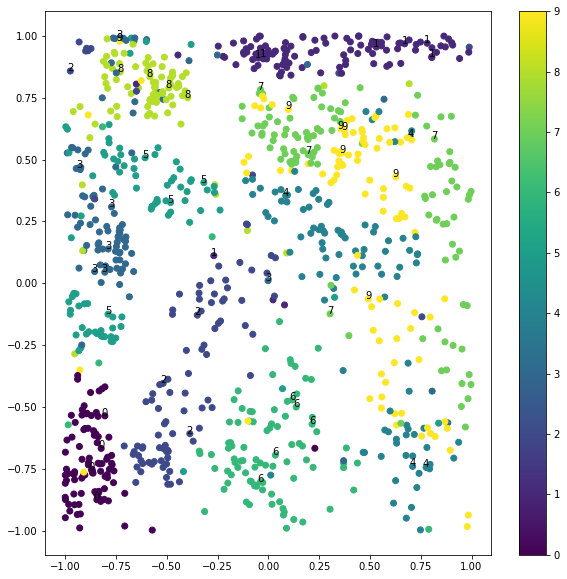

In [16]:
## Plot the embedding of 1000 digits
# Test
large_batch = torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=1000, 
                                          shuffle=False)

with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
#     print('targets[:20]: {}'.format(targets[:20]))
#     print('latentVar[:20]: {}'.format(latentVar[:20]))
#     fig.colorbar(pos, ax=ax)
    
    plt.colorbar(ticks=range(10))
#     plt.clim(-0.5, 9.5)
#     labels = np.arange(0,11,1)
#     print('labels: {}'.format(labels))
# #     loc    = labels + .5
#     print('loc: {}'.format(loc))
#     cb.set_ticks(loc)
#     cb.set_ticklabels(labels)
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
#     _, predicted = torch.max(out, 1)
#     print('predicted[:20]: \t{}'.format(predicted[:20]))
#     print('targets[:20]: \t\t{}'.format(targets[:20]))

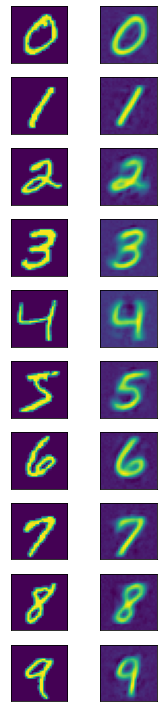

In [17]:
with torch.no_grad():
    data, targets = next(iter(large_batch))
#     print('targets.shape: {}'.format(targets.shape))
#     print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
#     print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    model_input = model_input.cpu().numpy()
    out = out.cpu().numpy()

    fig,ax = plt.subplots(10,2,figsize=(3,10))
    ax = ax.ravel()
    count=0
    for idx1 in range(10):
        for idx2 in range(len(targets)): #Looking for the digit among the labels
            if idx1==targets[idx2]:
                ax[count].imshow(model_input[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                ax[count].imshow(out[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                break

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[-0.78912675 -0.12499836]
 [-0.8698175  -0.7543111 ]
 [ 0.71004164 -0.739895  ]
 [-0.02738396  0.91609204]
 [ 0.49097097 -0.06348104]
 [-0.38629055 -0.60775614]
 [ 0.80433494  0.91521853]
 [-0.80477333  0.0447756 ]
 [ 0.7815945   0.9698337 ]
 [ 0.08535571  0.35410866]
 [-0.7718273   0.30855998]
 [-0.31743115  0.40678015]
 [-0.931607    0.46692327]
 [-0.03824825 -0.80196255]
 [ 0.67108154  0.9674482 ]
 [ 0.1988132   0.52361214]
 [-0.5176877  -0.4043672 ]
 [-0.49008605  0.7887214 ]
 [ 0.13715878 -0.5000531 ]
 [ 0.35774496  0.62402   ]]
x0,y0: -0.7891267538070679,-0.12499836087226868
x1,y1: -0.8698174953460693,-0.7543110847473145
xvals: [-0.78912675 -0.79809239 -0.80705803 -0.81602367 -0.82498931 -0.83395494
 -0.84292058 -0.85188622 -0.86085186 -0.8698175 ]
yvals: [-0.12499836 -0.194922   -0.26484563 -0.

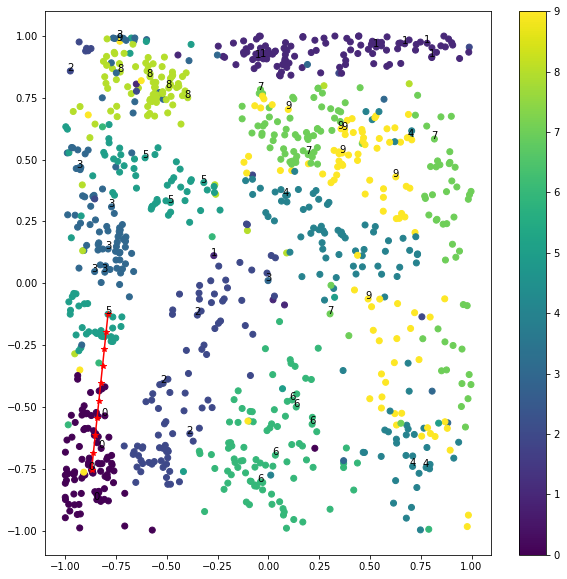

In [18]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

In [19]:
class AE_decoder(nn.Module):
    "Bert Model : Masked LM and next sentence classification"
    def __init__(self):
        super(AE_decoder, self).__init__()
        self.dec_lin1 = model_AE.dec_lin1
        self.dec_lin2 = model_AE.dec_lin2
        self.dec_lin3 = model_AE.dec_lin3 
        self.dec_lin4 = model_AE.dec_lin4
        
        self.tanh = nn.Tanh()

    def forward(self,z):
        # ditto, but in reverse
        print('z: {}'.format(z))
        print('z.shape: {}'.format(z.shape))
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

model_input: tensor([-0.7891, -0.1250])
z: tensor([-0.7891, -0.1250], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.7981, -0.1949])
z: tensor([-0.7981, -0.1949], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8071, -0.2648])
z: tensor([-0.8071, -0.2648], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8160, -0.3348])
z: tensor([-0.8160, -0.3348], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8250, -0.4047])
z: tensor([-0.8250, -0.4047], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8340, -0.4746])
z: tensor([-0.8340, -0.4746], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8429, -0.5445])
z: tensor([-0.8429, -0.5445], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8519, -0.6145])
z: tensor([-0.8519, -0.6145], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.8609, -0.6844])
z: tensor([-0.8609, -0.6844], device='cuda:0')
z.shape: torch.Si

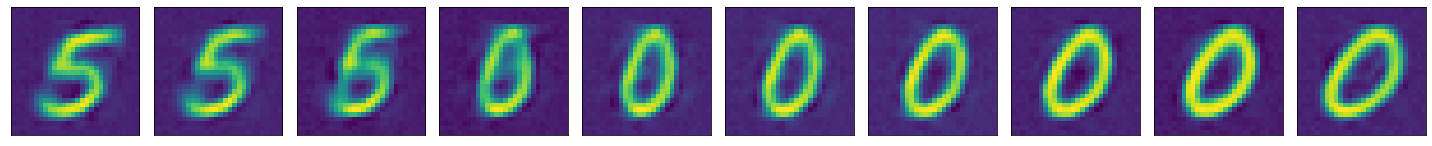

In [20]:
# Decode the interpolated points across classes
# model_AE = Autoencoder().float()
# model_AE.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_AE.pt'))
# print(model_AE)
    
with torch.no_grad():
#     data, targets = next(iter(large_batch))
#     print('targets.shape: {}'.format(targets.shape))
#     print('np.unique(targets): {}'.format(np.unique(targets)))
#     model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1
#                 break

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
[13 18]
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[-0.78912675 -0.12499836]
 [-0.8698175  -0.7543111 ]
 [ 0.71004164 -0.739895  ]
 [-0.02738396  0.91609204]
 [ 0.49097097 -0.06348104]
 [-0.38629055 -0.60775614]
 [ 0.80433494  0.91521853]
 [-0.80477333  0.0447756 ]
 [ 0.7815945   0.9698337 ]
 [ 0.08535571  0.35410866]
 [-0.7718273   0.30855998]
 [-0.31743115  0.40678015]
 [-0.931607    0.46692327]
 [-0.03824825 -0.80196255]
 [ 0.67108154  0.9674482 ]
 [ 0.1988132   0.52361214]
 [-0.5176877  -0.4043672 ]
 [-0.49008605  0.7887214 ]
 [ 0.13715878 -0.5000531 ]
 [ 0.35774496  0.62402   ]]
x0,y0: -0.038248252123594284,-0.8019625544548035
x1,y1: 0.13715878129005432,-0.5000531077384949
xvals: [-0.03824825 -0.01875858  0.00073109  0.02022076  0.03971043  0.0592001
  0.07868977  0.09817944  0.11766911  0.13715878]
yvals: [-0.80196255 -0.76841706 -0.7348

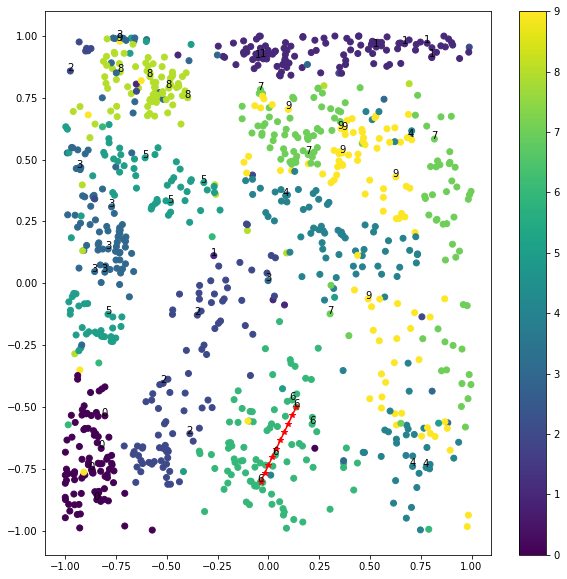

In [21]:
# Interpolate between two images of the same class
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    idx_ = np.where(targets==6)[0] # Get two '6'.
    print(idx_[:2])

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

model_input: tensor([-0.0382, -0.8020])
z: tensor([-0.0382, -0.8020], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([-0.0188, -0.7684])
z: tensor([-0.0188, -0.7684], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 7.3109e-04, -7.3487e-01])
z: tensor([ 7.3109e-04, -7.3487e-01], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.0202, -0.7013])
z: tensor([ 0.0202, -0.7013], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.0397, -0.6678])
z: tensor([ 0.0397, -0.6678], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.0592, -0.6342])
z: tensor([ 0.0592, -0.6342], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.0787, -0.6007])
z: tensor([ 0.0787, -0.6007], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.0982, -0.5671])
z: tensor([ 0.0982, -0.5671], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 0.1177, -0.5336])
z: tensor([ 0.1177, -0.5336], device='cuda:0')
z

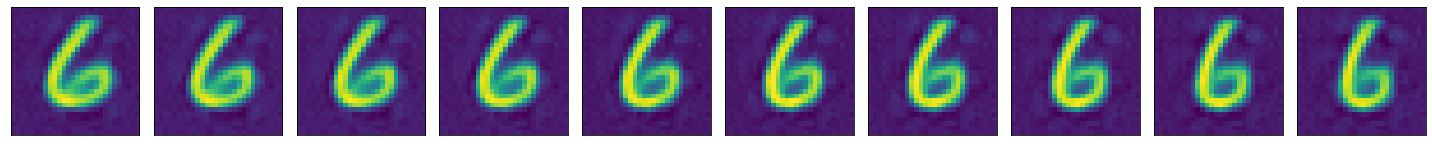

In [22]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

In [23]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(784, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 784)
        
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = x
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [24]:
lr_range = [0.01,0.005,0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,verbose=False)

#     # Test
#     with torch.no_grad():
#         data, targets = next(iter(test_loader))
#         model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
#         out = model(model_input)
#         _, predicted = torch.max(out, 1)
#         print('predicted[:20]: \t{}'.format(predicted[:20]))
#         print('targets[:20]: \t\t{}'.format(targets[:20]))

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.8733. Test loss: 0.8704. Time: 9.5166
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.4807
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.4715
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.4749
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.4786
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.4185
 EPOCH 60. Progress: 60.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.5123
 EPOCH 70. Progress: 70.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.6312
 EPOCH 80. Progress: 80.0%. 
 Train loss: 0.8744. Test loss: 0.8715. Time: 9.4646

In [37]:
# Training for longer with the lr that gave best result
lr_range = [0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, train_loader, test_loader,num_epochs=500,verbose=False)
    
# Save the trained model 
torch.save(model.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_AE_linear.pt')

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0471. Test loss: 0.0471. Time: 13.4549
 EPOCH 10. Progress: 2.0%. 
 Train loss: 0.0373. Test loss: 0.0374. Time: 14.0114
 EPOCH 20. Progress: 4.0%. 
 Train loss: 0.0354. Test loss: 0.0357. Time: 13.0047
 EPOCH 30. Progress: 6.0%. 
 Train loss: 0.0348. Test loss: 0.0352. Time: 13.0351
 EPOCH 40. Progress: 8.0%. 
 Train loss: 0.0343. Test loss: 0.0347. Time: 13.4061
 EPOCH 50. Progress: 10.0%. 
 Train loss: 0.0339. Test loss: 0.0344. Time: 13.6598
 EPOCH 60. Progress: 12.0%. 
 Train loss: 0.0335. Test loss: 0.0342. Time: 13.6884
 EPOCH 70. Progress: 14.000000000000002%. 
 Train loss: 0.0332. Test loss: 0.0340. Time: 13.4423
 EPOCH 80. Progress: 16.0%. 
 Train loss: 0.0329. Test loss: 0

In [8]:
# Load the model
model_AE_linear = Autoencoder().to(device)
model_AE_linear.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_AE_linear.pt'))

<All keys matched successfully>

In [17]:
class AE_decoder(nn.Module):
    "Bert Model : Masked LM and next sentence classification"
    def __init__(self):
        super(AE_decoder, self).__init__()
        self.dec_lin1 = model_AE_linear.dec_lin1
        self.dec_lin2 = model_AE_linear.dec_lin2
        self.dec_lin3 = model_AE_linear.dec_lin3 
        self.dec_lin4 = model_AE_linear.dec_lin4
        
        self.tanh = nn.Tanh()

    def forward(self,z):
        # ditto, but in reverse
        print('z: {}'.format(z))
        print('z.shape: {}'.format(z.shape))
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

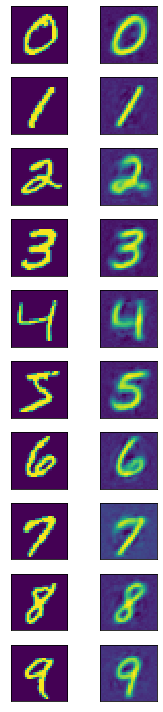

In [12]:
large_batch = torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=1000, 
                                          shuffle=False)

with torch.no_grad():
    data, targets = next(iter(large_batch))
#     print('targets.shape: {}'.format(targets.shape))
#     print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE_linear(model_input)
#     print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    model_input = model_input.cpu().numpy()
    out = out.cpu().numpy()

    fig,ax = plt.subplots(10,2,figsize=(3,10))
    ax = ax.ravel()
    count=0
    for idx1 in range(10):
        for idx2 in range(len(targets)): #Looking for the digit among the labels
            if idx1==targets[idx2]:
                ax[count].imshow(model_input[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                ax[count].imshow(out[idx2].reshape(28,28))
                ax[count].set_xticks([])
                ax[count].set_yticks([])
                count+=1
                break

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
[13 18]
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[  1.0616698   -0.05738619]
 [ 11.909519    -0.90193176]
 [  0.17360753  10.880561  ]
 [-14.70645    -17.591257  ]
 [ -3.2908397    3.11914   ]
 [  8.206937   -16.972162  ]
 [-18.47332     -3.219505  ]
 [  0.744113     0.6655234 ]
 [-22.749912    -7.959337  ]
 [ -9.08559      5.89852   ]
 [  1.2920568    1.6057959 ]
 [ -1.7533536   -5.3223805 ]
 [  3.008552     3.0833027 ]
 [  5.930649    -4.361267  ]
 [-22.922874    -6.529972  ]
 [-15.991485    13.868627  ]
 [  5.6687074  -21.324507  ]
 [ -6.1826015   -4.3941073 ]
 [  3.3187346   -1.1391597 ]
 [ -8.461947     1.7730477 ]]
x0,y0: 5.9306488037109375,-4.36126708984375
x1,y1: 3.318734645843506,-1.1391596794128418
xvals: [5.9306488  5.64043612 5.35022344 5.06001075 4.76979807 4.47958538
 4.1893727  3.89916001 3.60894733 3.31873465]
yvals: [-4.3612

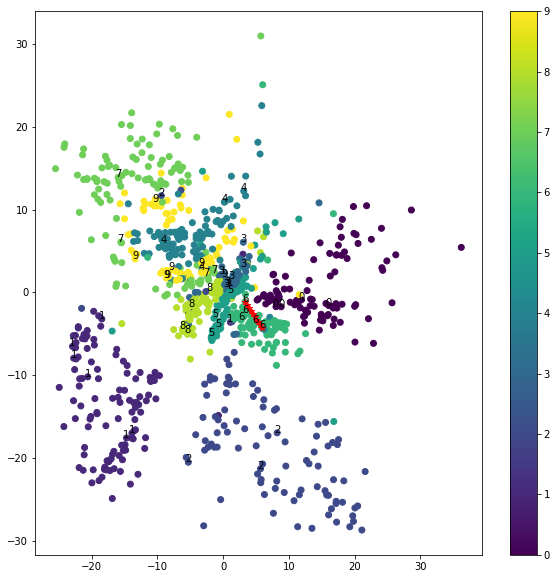

In [14]:
# Interpolate between two images of the same class
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE_linear(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()
    idx_ = np.where(targets==6)[0] # Get two '6'.
    print(idx_[:2])

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

model_input: tensor([ 5.9306, -4.3613])
z: tensor([ 5.9306, -4.3613], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 5.6404, -4.0033])
z: tensor([ 5.6404, -4.0033], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 5.3502, -3.6452])
z: tensor([ 5.3502, -3.6452], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 5.0600, -3.2872])
z: tensor([ 5.0600, -3.2872], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 4.7698, -2.9292])
z: tensor([ 4.7698, -2.9292], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 4.4796, -2.5712])
z: tensor([ 4.4796, -2.5712], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 4.1894, -2.2132])
z: tensor([ 4.1894, -2.2132], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 3.8992, -1.8552])
z: tensor([ 3.8992, -1.8552], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 3.6089, -1.4972])
z: tensor([ 3.6089, -1.4972], device='cuda:0')
z.shape: torch.Si

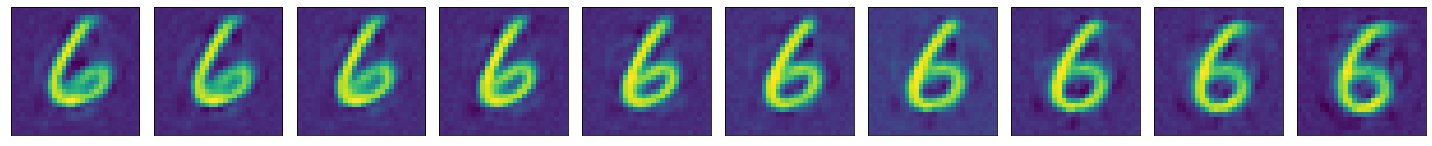

In [18]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

targets.shape: torch.Size([1000])
np.unique(targets): [0 1 2 3 4 5 6 7 8 9]
latentVar.shape: torch.Size([1000, 2])
targets[:20]: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
latentVar[:20]: [[  1.0616698   -0.05738619]
 [ 11.909519    -0.90193176]
 [  0.17360753  10.880561  ]
 [-14.70645    -17.591257  ]
 [ -3.2908397    3.11914   ]
 [  8.206937   -16.972162  ]
 [-18.47332     -3.219505  ]
 [  0.744113     0.6655234 ]
 [-22.749912    -7.959337  ]
 [ -9.08559      5.89852   ]
 [  1.2920568    1.6057959 ]
 [ -1.7533536   -5.3223805 ]
 [  3.008552     3.0833027 ]
 [  5.930649    -4.361267  ]
 [-22.922874    -6.529972  ]
 [-15.991485    13.868627  ]
 [  5.6687074  -21.324507  ]
 [ -6.1826015   -4.3941073 ]
 [  3.3187346   -1.1391597 ]
 [ -8.461947     1.7730477 ]]
x0,y0: 1.0616698265075684,-0.05738619342446327
x1,y1: 11.90951919555664,-0.9019317626953125
xvals: [ 1.06166983  2.26698642  3.47230302  4.67761962  5.88293621  7.08825281
  8.29356941  9.498886   10.7042026  11.9095192 ]
yvals: [-0

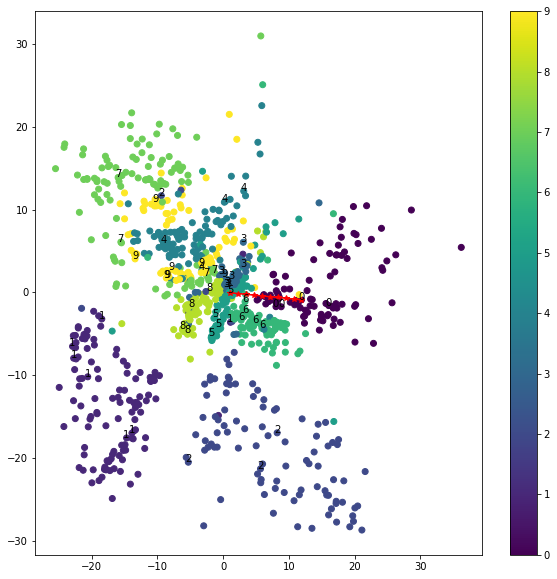

In [19]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(large_batch))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model_AE_linear(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(10))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')
    

model_input: tensor([ 1.0617, -0.0574])
z: tensor([ 1.0617, -0.0574], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 2.2670, -0.1512])
z: tensor([ 2.2670, -0.1512], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 3.4723, -0.2451])
z: tensor([ 3.4723, -0.2451], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 4.6776, -0.3389])
z: tensor([ 4.6776, -0.3389], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 5.8829, -0.4327])
z: tensor([ 5.8829, -0.4327], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 7.0883, -0.5266])
z: tensor([ 7.0883, -0.5266], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 8.2936, -0.6204])
z: tensor([ 8.2936, -0.6204], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([ 9.4989, -0.7143])
z: tensor([ 9.4989, -0.7143], device='cuda:0')
z.shape: torch.Size([2])
model_input: tensor([10.7042, -0.8081])
z: tensor([10.7042, -0.8081], device='cuda:0')
z.shape: torch.Si

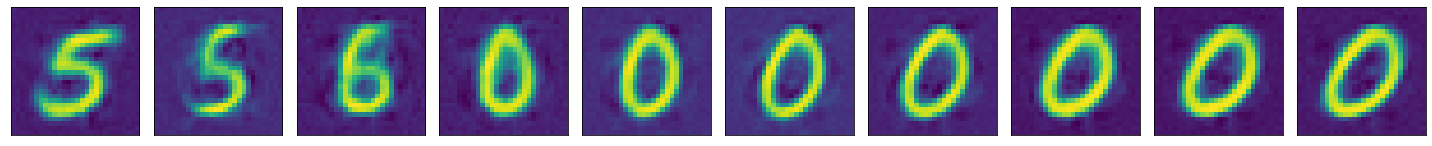

In [20]:
with torch.no_grad():

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = torch.from_numpy(model_input).float()

        print('model_input: {}'.format(model_input))
        model = AE_decoder()

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1

fig.tight_layout()

## Question 3.1.1. 
__Do the colors easily separate, or are they all clumped together? Which numbers are frequently embedded close together, and what does this mean?__

We can observe that the autoencoder architectures used (either with 'tanh' activations everywhere or linear ativations in the middle layer) are capable of identifying the underlying structure of the data and form clusters in the latent space, although the architecture with all non-linearity seems to do a better job in spreading out the data points. Some of the digits that are constantly near each other in the latent space are the '9', '4' and '7'. This indicates an elevated degree of similarity between these digits, which well correlates with observations of these digits.

## Question 3.1.2. 
__How realistic were the images you generated by interpolating between points in the latent space? Can you think of a better way to generate images with an autoencoder?__

The generated images were quite realistic for digits generated by interpolation within clusters. When interpolating between clusters, the images were in general less sharp and less realistic, almost as if there were overlapping digits in the image. 
A better way to generate images with an autoencoders would be to enforece a more structured latent space with less gaps between the clusters, such as done in variatonal autoencoders (VAE)

## Section 3.2

In [42]:
# Load the retinal bipolar cells dataset 
bipolar_data = pd.read_pickle('../data/retinal-bipolar-data.pickle').to_numpy();
bipolar_meta = pd.read_pickle('../data/retinal-bipolar-metadata.pickle')#, na_value=np.nan);
bipolar_meta = bipolar_meta.iloc[:, 0].to_numpy(dtype='float')
# bipolar_all = pd.concat([bipolar_data_pca, bipolar_meta],axis=1)

print('bipolar_data.shape: {}'.format(bipolar_data.shape))
print('bipolar_meta.shape: {}'.format(bipolar_meta.shape))

bipolar_data.shape: (21552, 15524)
bipolar_meta.shape: (21552,)


In [54]:
# split in training and testing
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from scipy.ndimage import zoom


class MyDataset(Dataset):
    def __init__(self, data, target):
        print('data.dtype: {}'.format(data.dtype))
        print('target.dtype: {}'.format(target.dtype))
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

print('bipolar_meta[:,0].shape: {}'.format(bipolar_meta))
dataset = MyDataset(bipolar_data, bipolar_meta)
dataset_size  = len(dataset)
print('dataset_size: {}'.format(dataset_size))
test_split=0.2

# Number of frames in the sequence (in this case, same as number of tokens). Maybe I can make this number much bigger, like 4 times bigger, and then do the batches of batches...
# For example, when classifying, I can test if the first and the second chunk are sequence vs the first and third
batch_size=128 #Originally 16 frames... can I do 128 and then split in 4 chunks of 32

# -- split dataset
indices       = list(range(dataset_size))
split         = int(np.floor(test_split*dataset_size))
print('split: {}'.format(split))
# np.random.shuffle(indices) # Randomizing the indices is not a good idea if you want to model the sequence
train_indices, val_indices = indices[split:], indices[:split]
# print('train_indices[:50]: {}'.format(train_indices[:50]))


# -- create dataloaders
# #Original
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders   = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=6, sampler=valid_sampler),
    'all': torch.utils.data.DataLoader(dataset,  batch_size=dataset_size, num_workers=6, shuffle=False),
    }

bipolar_meta[:,0].shape: [ 3.  9.  5. ... -1. -1. -1.]
data.dtype: float64
target.dtype: float64
dataset_size: 21552
split: 4310


In [49]:
class Autoencoder(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function)
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_lin1 = nn.Linear(15524, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 2)
        
        self.dec_lin1 = nn.Linear(2, 250)
        self.dec_lin2 = nn.Linear(250, 500)
        self.dec_lin3 = nn.Linear(500, 1000)
        self.dec_lin4 = nn.Linear(1000, 15524)
        
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.tanh(x)
        x = self.enc_lin2(x)
        x = self.tanh(x)
        x = self.enc_lin3(x)
        x = self.tanh(x)
        x = self.enc_lin4(x)
        z = x
        return z

    def decode(self, z):
        # ditto, but in reverse
        x = self.dec_lin1(z)
        x = self.tanh(x)
        x = self.dec_lin2(x)
        x = self.tanh(x)
        x = self.dec_lin3(x)
        x = self.tanh(x)
        x = self.dec_lin4(x)
        x = self.tanh(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

In [51]:
lr_range = [0.01,0.005,0.001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],verbose=False)

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 1.3988. Test loss: 1.3945. Time: 4.3650
 EPOCH 10. Progress: 10.0%. 
 Train loss: 1.4038. Test loss: 1.3995. Time: 4.1948
 EPOCH 20. Progress: 20.0%. 
 Train loss: 1.4054. Test loss: 1.4011. Time: 4.1780
 EPOCH 30. Progress: 30.0%. 
 Train loss: 1.4065. Test loss: 1.4022. Time: 4.1666
 EPOCH 40. Progress: 40.0%. 
 Train loss: 1.4067. Test loss: 1.4025. Time: 4.1775
 EPOCH 50. Progress: 50.0%. 
 Train loss: 1.4069. Test loss: 1.4027. Time: 4.1675
 EPOCH 60. Progress: 60.0%. 
 Train loss: 1.4070. Test loss: 1.4027. Time: 4.1842
 EPOCH 70. Progress: 70.0%. 
 Train loss: 1.4069. Test loss: 1.4027. Time: 4.2006
 EPOCH 80. Progress: 80.0%. 
 Train loss: 1.4069. Test loss: 1.4027. Time: 4.1711

In [55]:
lr_range = [0.0001]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],num_epochs=500,verbose=False)
    
torch.save(model.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_AE_retinal.pt')

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.5357. Test loss: 0.5327. Time: 4.2121
 EPOCH 10. Progress: 2.0%. 
 Train loss: 0.5308. Test loss: 0.5282. Time: 4.2044
 EPOCH 20. Progress: 4.0%. 
 Train loss: 0.5299. Test loss: 0.5276. Time: 4.1937
 EPOCH 30. Progress: 6.0%. 
 Train loss: 0.5294. Test loss: 0.5274. Time: 4.2101
 EPOCH 40. Progress: 8.0%. 
 Train loss: 0.5289. Test loss: 0.5271. Time: 4.2770
 EPOCH 50. Progress: 10.0%. 
 Train loss: 0.5284. Test loss: 0.5269. Time: 4.2060
 EPOCH 60. Progress: 12.0%. 
 Train loss: 0.5280. Test loss: 0.5268. Time: 4.2180
 EPOCH 70. Progress: 14.000000000000002%. 
 Train loss: 0.5277. Test loss: 0.5266. Time: 4.1943
 EPOCH 80. Progress: 16.0%. 
 Train loss: 0.5276. Test loss: 0.5266. 

In [60]:
lr_range = [0.0005]
print('Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else')
# for hid_dim in hid_dim_range:
for lr in lr_range:
#         print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
    if 'model' in globals():
        print('Deleting previous model')
        del model
    model = Autoencoder().to(device)
    ADAM = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
    # initialize the loss function. You don't want to use this one, so change it accordingly
    loss_fn = nn.MSELoss().to(device)
    train(model,loss_fn, ADAM, dataloaders['train'], dataloaders['test'],num_epochs=500,verbose=False)
    
torch.save(model.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_AE_retinal2.pt')

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.5353. Test loss: 0.5325. Time: 4.1828
 EPOCH 10. Progress: 2.0%. 
 Train loss: 0.5295. Test loss: 0.5277. Time: 4.2820
 EPOCH 20. Progress: 4.0%. 
 Train loss: 0.5283. Test loss: 0.5270. Time: 4.1947
 EPOCH 30. Progress: 6.0%. 
 Train loss: 0.5277. Test loss: 0.5268. Time: 4.2342
 EPOCH 40. Progress: 8.0%. 
 Train loss: 0.5273. Test loss: 0.5267. Time: 4.2384
 EPOCH 50. Progress: 10.0%. 
 Train loss: 0.5270. Test loss: 0.5267. Time: 4.2363
 EPOCH 60. Progress: 12.0%. 
 Train loss: 0.5266. Test loss: 0.5268. Time: 4.2506
 EPOCH 70. Progress: 14.000000000000002%. 
 Train loss: 0.5263. Test loss: 0.5268. Time: 4.2325
 EPOCH 80. Progress: 16.0%. 
 Train loss: 0.5260. Test loss: 0.5268. 

In [65]:
# Load the model
model = Autoencoder().to(device)
model.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_AE_retinal.pt'))

<All keys matched successfully>

targets.shape: torch.Size([21552])
np.unique(targets): [-1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]
latentVar.shape: torch.Size([21552, 2])
targets[:20]: [ 3.  9.  5.  1.  5.  9.  8.  3.  1.  2. 13.  5.  1. 21.  1.  1. 19.  5.
  6.  1.]
latentVar[:20]: [[  2.6436138    2.1380448 ]
 [-10.543611   -12.975954  ]
 [  4.2293687  -28.020527  ]
 [ 17.188044   -18.904572  ]
 [  9.019685    -5.5473638 ]
 [-11.528287   -13.243637  ]
 [ -0.5243033   -0.12976809]
 [  3.9631467    2.4148932 ]
 [ 20.484415   -20.320663  ]
 [ -4.1037574    6.4289336 ]
 [  0.7516669    0.17887418]
 [ 16.674221    -5.3746543 ]
 [ 13.804541   -12.567362  ]
 [ -1.4213532  -33.89462   ]
 [ 19.675438   -19.555912  ]
 [ 11.191798   -26.77504   ]
 [  3.140667   -33.317314  ]
 [ 22.626192    -7.5875144 ]
 [ -0.10698389  -0.2384981 ]
 [ 22.552475   -22.229588  ]]


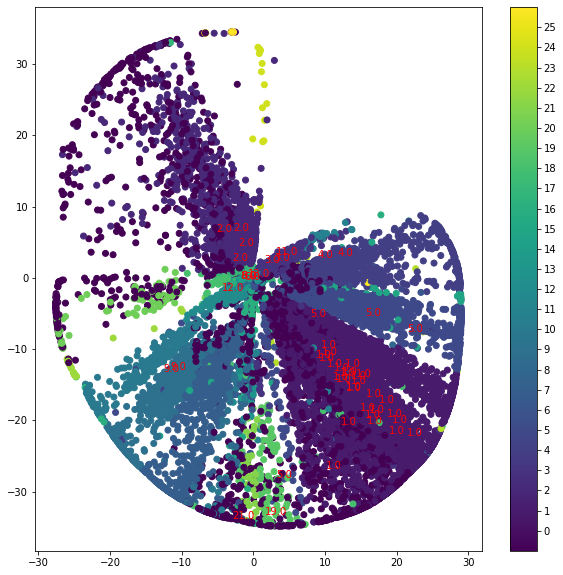

In [66]:
# Interpolate between two images of different classes
with torch.no_grad():
    data, targets = next(iter(dataloaders['all']))
    print('targets.shape: {}'.format(targets.shape))
    print('np.unique(targets): {}'.format(np.unique(targets)))
    model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    out, latentVar = model(model_input)
    print('latentVar.shape: {}'.format(latentVar.shape))
    latentVar = latentVar.cpu().numpy()
    targets = targets.numpy()

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:])
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))
    
    plt.colorbar(ticks=range(26))
    n_points=50
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

## Question 3.2.1. 
__How many clusters are visible in the embedding? Do they correspond to the cluster labels?__

The plot of the latent space of the retinal bipolar cells shows some degree of organization by color, thus indicating that the labels assigned to the datapoints are coherent. However, no clear separation between clusters is observed. This indicates that the cluster assignment used for this dataset might be based on some other metric or priori (likely biological) knowledge rather than the structure of the latent space.

# Section 4 - Generative Models

## Section 4.1 - Variational Autoencoder

In [9]:
'''
Ref: https://github.com/pytorch/examples/blob/master/vae/main.py
'''

import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# parser = argparse.ArgumentParser(description='VAE MNIST Example') # collect arguments passed to file
# parser.add_argument('--batch_size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')

class Args:
    batch_size = 128
    epochs = 50
    seed = 1
    no_cuda=False
    log_interval=100

args=Args()
# print(args.batch_size)

# args = parser.parse_args(" ")
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu") # Use NVIDIA CUDA GPU if available

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_MSE = nn.MSELoss().to(device)

def VAE_loss_function(recon_x, x, mu, logvar):
    
    # TO DO: Implement reconstruction + KL divergence losses summed over all elements and batch

    # see lecture 12 slides for more information on the VAE loss function
    # for additional information on computing KL divergence
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    
#     print('recon_x.shape: {}'.format(recon_x.shape))
#     print('x.shape: {}'.format(x.shape))
#     print('x.view(-1,784).shape: {}'.format(x.view(-1,784).shape))
#     print('mu.shape: {}'.format(mu.shape))
#     print('logvar.shape: {}'.format(logvar.shape))
#     print('recon_x: {}'.format(recon_x))
#     print('x.view(-1,784): {}'.format(x.view(-1,784)))
    # Compute the reconstruction loss
#     recon_loss = F.mse_loss(recon_x, x.view(-1,784))
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1,784), reduction='sum')
    
#     print(recon_loss)
    
    # Compute the KLD
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     print(KLD)
    
    return recon_loss, KLD


def train(epoch):
    model.train()
    train_loss = 0
    train_KLD=0
    train_recon_loss=0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss, KLD = VAE_loss_function(recon_batch, data, mu, logvar)
        loss = recon_loss + KLD
        loss.backward()
        train_loss += loss.item()
        train_KLD += KLD.item()
        train_recon_loss += recon_loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
#                 recon_loss.item() / len(data),
#                 KLD.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.6f} (Loss_recon: {:.6f}, Loss_KLD: {:.6f})'.format(
          epoch, train_loss / len(train_loader.dataset), train_recon_loss/ len(train_loader.dataset),
                train_KLD / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    test_KLD=0
    test_recon_loss=0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
#             test_loss += VAE_loss_function(recon_batch, data, mu, logvar).item()
            recon_loss, KLD = VAE_loss_function(recon_batch, data, mu, logvar)
            loss = recon_loss + KLD
            test_recon_loss += recon_loss.item()
            test_KLD += KLD.item()
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         './plots_VAE/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.6f} (Loss_recon: {:.6f}, Loss_KLD: {:.6f})\n'.format(test_loss, test_recon_loss/ len(test_loader.dataset),
                test_KLD / len(test_loader.dataset)))


if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       './plots_VAE/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.800781
Train Epoch: 1 [12800/60000 (21%)]	Loss: 273.464539
Train Epoch: 1 [25600/60000 (43%)]	Loss: 225.432953
Train Epoch: 1 [38400/60000 (64%)]	Loss: 220.655640
Train Epoch: 1 [51200/60000 (85%)]	Loss: 209.825394
====> Epoch: 1 Average loss: 260.239216 (Loss_recon: 244.108071, Loss_KLD: 16.131145)
====> Test set loss: 196.261541 (Loss_recon: 181.366574, Loss_KLD: 14.894966)

Train Epoch: 2 [0/60000 (0%)]	Loss: 190.857315
Train Epoch: 2 [12800/60000 (21%)]	Loss: 181.354874
Train Epoch: 2 [25600/60000 (43%)]	Loss: 172.912720
Train Epoch: 2 [38400/60000 (64%)]	Loss: 171.677307
Train Epoch: 2 [51200/60000 (85%)]	Loss: 171.846634
====> Epoch: 2 Average loss: 177.667175 (Loss_recon: 161.176400, Loss_KLD: 16.490775)
====> Test set loss: 163.753003 (Loss_recon: 145.761178, Loss_KLD: 17.991826)

Train Epoch: 3 [0/60000 (0%)]	Loss: 160.707336
Train Epoch: 3 [12800/60000 (21%)]	Loss: 157.860580
Train Epoch: 3 [25600/60000 (43%)]	Loss: 154.253662
Train Epo

In [10]:
# Save the model
torch.save(model.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_VAE.pt')

In [11]:
# Load the model 
model_VAE = VAE().to(device)
model_VAE.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_VAE.pt'))

<All keys matched successfully>

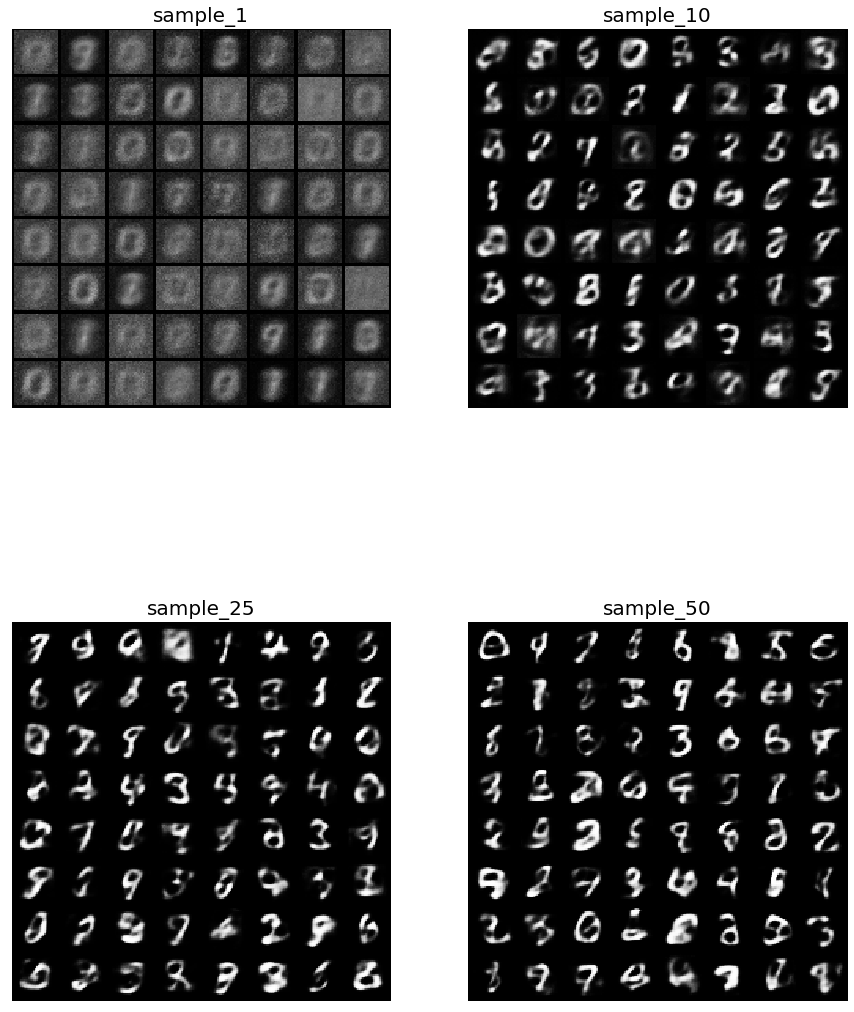

In [39]:
# Load some of the images
from PIL import Image

fig,ax = plt.subplots(2,2,figsize=(15,20))
ax = ax.ravel()
img0 = np.array(Image.open('./plots_VAE/sample_1.png'))
img10 = np.array(Image.open('./plots_VAE/sample_10.png'))
img25 = np.array(Image.open('./plots_VAE/sample_25.png'))
img50 = np.array(Image.open('./plots_VAE/sample_50.png'))
# img100 = np.array(Image.open('./plots_VAE/sample_40.png'))
# img250 = np.array(Image.open('./plots_VAE/gen_img250.png'))
# img500 = np.array(Image.open('./plots_VAE/gen_img500.png'))
# img750 = np.array(Image.open('./plots_VAE/gen_img750.png'))
# img800 = np.array(Image.open('./plots_VAE/gen_img800.png'))

ax[0].imshow(img0, cmap='gray'); #set colormap as 'gray'
ax[0].set_title("sample_1", fontsize=20);
ax[0].grid(False), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(img10, cmap='gray'); #set colormap as 'gray'
ax[1].set_title("sample_10", fontsize=20);
ax[1].grid(False), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(img25, cmap='gray'); #set colormap as 'gray'
ax[2].set_title("sample_25", fontsize=20);
ax[2].grid(False), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(img50, cmap='gray'); #set colormap as 'gray'
ax[3].set_title("sample_50", fontsize=20);
ax[3].grid(False), ax[3].set_xticks([]), ax[3].set_yticks([]);
# ax[4].imshow(img100, cmap='gray'); #set colormap as 'gray'
# ax[4].set_title("img100", fontsize=20);
# ax[5].imshow(img250, cmap='gray'); #set colormap as 'gray'
# ax[5].set_title("img250", fontsize=20);
# ax[6].imshow(img500, cmap='gray'); #set colormap as 'gray'
# ax[6].set_title("img500", fontsize=20);
# ax[7].imshow(img750, cmap='gray'); #set colormap as 'gray'
# ax[7].set_title("img750", fontsize=20);
# ax[8].imshow(img800, cmap='gray'); #set colormap as 'gray'
# ax[8].set_title("img800", fontsize=20);

# pentagon_right = './stereo/Pentagon-Right.tiff'
# pentagon_right = np.array(Image.open(pentagon_right))

targets[:20]: [8 1 4 4 2 5 3 5 7 3 1 1 1 6 7 3 4 6 7 0]
latentVar[:20]: [[-0.5417128   2.518082  ]
 [-2.6735961  -0.5087692 ]
 [ 0.33235195 -0.12619334]
 [ 2.875569   -0.82842124]
 [-0.13903669  1.9893227 ]
 [ 0.13168612 -0.2851772 ]
 [ 0.21893919  1.24577   ]
 [ 0.5854756   0.85330206]
 [-0.26694047 -2.274806  ]
 [-0.13837725  1.373421  ]
 [-2.4228451   0.3079988 ]
 [-2.967508   -0.14575993]
 [-2.7942457  -1.1356698 ]
 [-0.16625273 -1.2458692 ]
 [ 0.7393843  -1.594221  ]
 [-0.8539501   1.5111607 ]
 [-0.956067   -1.549401  ]
 [-1.6439222   0.01768674]
 [ 2.1768575  -1.2149682 ]
 [ 1.6360449   1.1609236 ]]
x0,y0: -0.5417128205299377,2.5180819034576416
x1,y1: -2.673596143722534,-0.5087692141532898
xvals: [-0.54171282 -0.77858875 -1.01546467 -1.25234059 -1.48921652 -1.72609244
 -1.96296837 -2.19984429 -2.43672022 -2.67359614]
yvals: [ 2.5180819   2.18176511  1.84544832  1.50913153  1.17281474  0.83649795
  0.50018116  0.16386437 -0.17245242 -0.50876921]


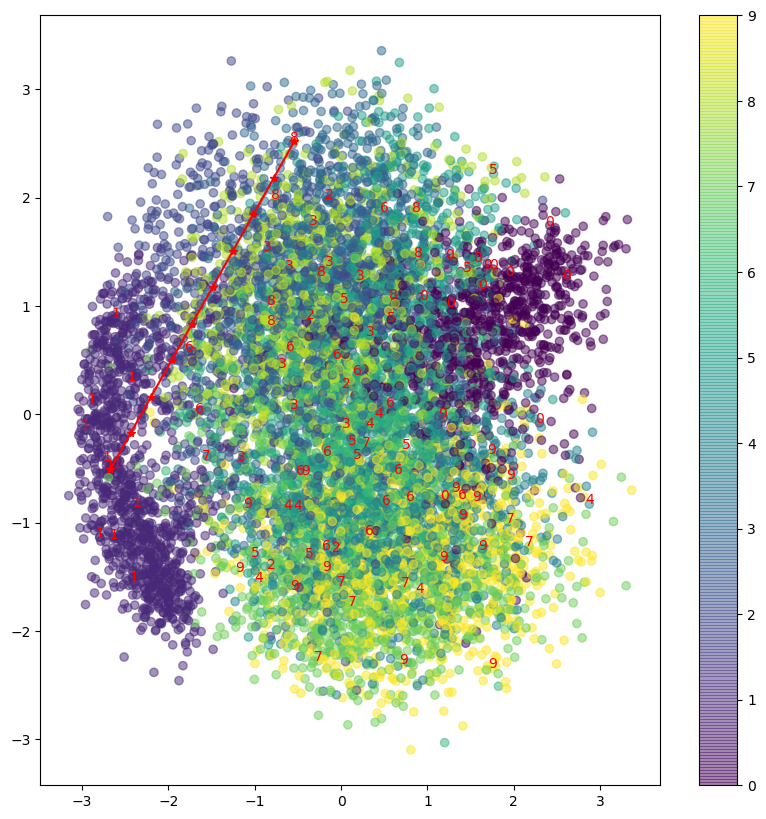

In [88]:
# Visualize the 2D space
# Should we use PCA to embeded the 20D to 2D? 
from sklearn.decomposition import PCA
matplotlib.style.use('default')
large_batch = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=20000, shuffle=True, **kwargs)

with torch.no_grad():
    model_VAE.eval()
    data, targets = next(iter(large_batch))
    targets = targets.numpy()
    data = data.to(device)
    recon_batch, mu, logvar = model_VAE(data)
    
    #Reduce dimensions to 2D
    pca = PCA(n_components=2)
    latentVar = pca.fit_transform(mu.cpu().numpy())
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=100
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):

        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[0,0],latentVar[0,1]
    x1,y1 = latentVar[1,0],latentVar[1,1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')

In [104]:
print(logvar.max())
print(logvar.mean())
print(logvar.min())
print(logvar.shape)
print(mu.shape)

tensor(-0.2879, device='cuda:0')
tensor(-2.4714, device='cuda:0')
tensor(-5.0382, device='cuda:0')
torch.Size([10000, 20])
torch.Size([10000, 20])


In [107]:
class VAE_decoder(nn.Module):
    def __init__(self):
        super(VAE_decoder, self).__init__()
#         self.dec_lin1 = model_VAE.dec_lin1
#         self.dec_lin2 = model_VAE.dec_lin2
#         self.dec_lin3 = model_VAE.dec_lin3 
#         self.dec_lin4 = model_VAE.dec_lin4
        
#         self.tanh = nn.Tanh()
        
        self.fc1 = model_VAE.fc1
        self.fc21 = model_VAE.fc21
        self.fc22 = model_VAE.fc22
        self.fc3 = model_VAE.fc3
        self.fc4 = model_VAE.fc4

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, mu):
#         mu, logvar = self.encode(x.view(-1, 784))
        logvar=torch.ones_like(mu) * -2.5
        z = self.reparameterize(mu, logvar)
        print('z.shape: {}'.format(z.shape))
        return self.decode(z)


model_input: tensor([ 0.3632, -1.2287,  0.7415,  0.5946,  0.3502,  0.0314,  1.1371,  1.0540,
         1.1119,  0.1505, -0.0988,  0.5703,  0.0733,  0.0311,  0.3284,  0.1863,
        -0.2899,  0.0365, -0.2746,  0.3841])
z.shape: torch.Size([20])
model_input: tensor([ 0.2787, -1.1115,  0.7801,  0.4842,  0.2505,  0.0534,  0.8796,  1.0240,
         1.0177,  0.1417, -0.1042,  0.5062,  0.0557,  0.1233,  0.2752,  0.3008,
        -0.2133, -0.0674, -0.2530,  0.3387])
z.shape: torch.Size([20])
model_input: tensor([ 0.1942, -0.9943,  0.8187,  0.3738,  0.1507,  0.0754,  0.6220,  0.9940,
         0.9235,  0.1329, -0.1095,  0.4421,  0.0381,  0.2155,  0.2220,  0.4153,
        -0.1368, -0.1712, -0.2314,  0.2933])
z.shape: torch.Size([20])
model_input: tensor([ 0.1097, -0.8771,  0.8573,  0.2635,  0.0510,  0.0974,  0.3645,  0.9640,
         0.8293,  0.1241, -0.1149,  0.3781,  0.0205,  0.3077,  0.1688,  0.5298,
        -0.0602, -0.2751, -0.2098,  0.2479])
z.shape: torch.Size([20])
model_input: tensor([ 0.

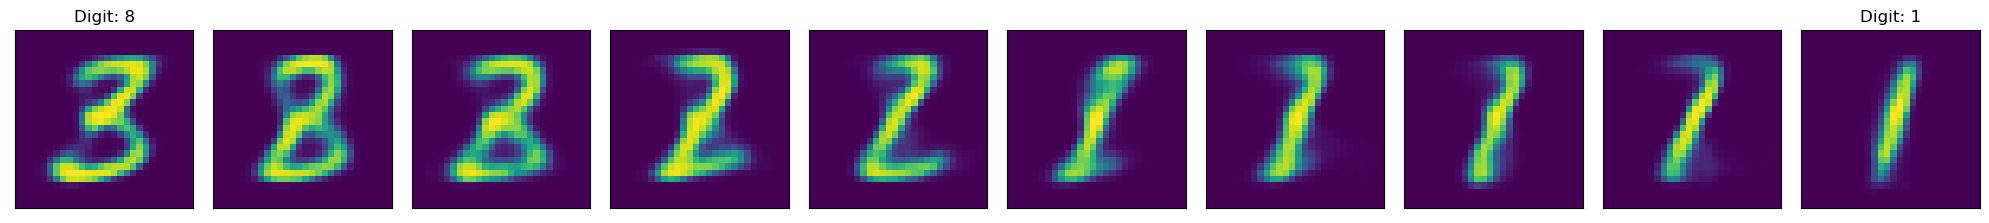

In [110]:
with torch.no_grad():

    model = VAE_decoder()

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = pca.inverse_transform(model_input) #Take it back to 20D
        model_input = torch.from_numpy(model_input).float()

#         print('model_input: {}'.format(model_input))

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1
ax[0].set_title('Digit: 8')
ax[9].set_title('Digit: 1')
fig.tight_layout()

[1 5]
targets[:20]: [4 1 9 9 6 1 0 9 4 6 3 9 2 0 3 4 4 1 5 5]
latentVar[:20]: [[-5.0794119e-01 -9.5312077e-01]
 [-2.5444672e+00 -3.8218644e-01]
 [-1.7153823e-01 -1.8550723e+00]
 [ 9.6620911e-01 -8.8855684e-01]
 [ 8.2021289e-02  1.5385058e-03]
 [-2.8620138e+00  1.3945606e-01]
 [ 1.7337507e+00  1.7632233e-01]
 [ 2.1378038e+00 -1.4119014e+00]
 [ 9.1303945e-01 -7.9664707e-01]
 [ 7.4553674e-01 -6.1926097e-01]
 [-6.9323909e-01  2.1264374e+00]
 [ 9.8548979e-01 -1.1609902e+00]
 [-4.1380054e-01  2.2895186e+00]
 [ 2.0185623e+00 -3.2814884e-01]
 [ 3.1647301e-01  1.7503246e+00]
 [-9.0527403e-01  1.7465185e-01]
 [-9.1545665e-01 -1.5315492e+00]
 [-1.7384877e+00  7.3413211e-01]
 [ 5.5839598e-01  1.0179104e+00]
 [-1.0396142e+00 -1.2391291e+00]]
x0,y0: -2.5444672107696533,-0.3821864426136017
x1,y1: -2.862013816833496,0.13945606350898743
xvals: [-2.54446721 -2.57975017 -2.61503312 -2.65031608 -2.68559904 -2.72088199
 -2.75616495 -2.7914479  -2.82673086 -2.86201382]
yvals: [-0.38218644 -0.32422616 -0.266

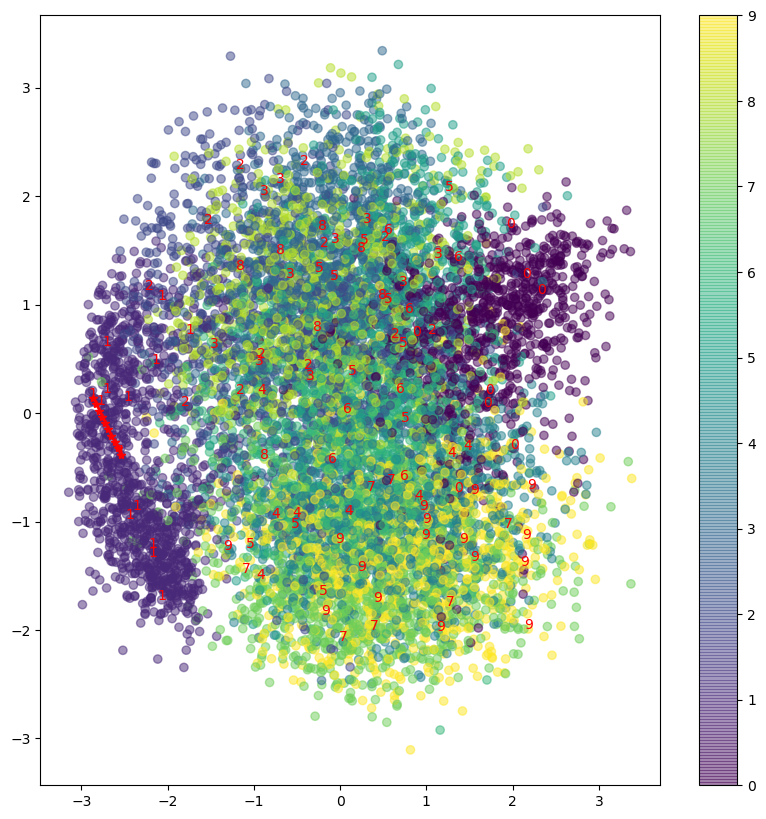

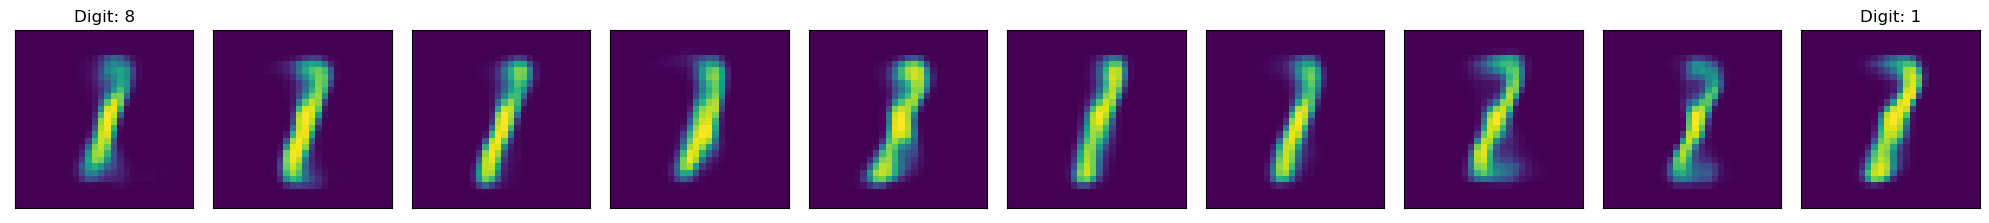

In [113]:
# Redo for digits in the same class
with torch.no_grad():
    model_VAE.eval()
    data, targets = next(iter(large_batch))
    targets = targets.numpy()
    idx_ = np.where(targets==1)[0] # Get two '6'.
    print(idx_[:2])
    data = data.to(device)
    recon_batch, mu, logvar = model_VAE(data)
    
    #Reduce dimensions to 2D
    pca = PCA(n_components=2)
    latentVar = pca.fit_transform(mu.cpu().numpy())
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.scatter(latentVar[:,0],latentVar[:,1],c=targets[:], alpha=0.5)
    print('targets[:20]: {}'.format(targets[:20]))
    print('latentVar[:20]: {}'.format(latentVar[:20]))

    plt.colorbar(ticks=range(26))
    n_points=100
    for x,y,i in zip(latentVar[:n_points,0],latentVar[:n_points,1],range(n_points)):
        label = targets[i]

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     c='r',
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # Get the first two points of latentVar
    x0,y0 = latentVar[idx_[0],0],latentVar[idx_[0],1]
    x1,y1 = latentVar[idx_[1],0],latentVar[idx_[1],1]
    xvals = np.array(np.linspace(x0, x1, 10))
    yvals = np.array(np.linspace(y0, y1, 10))
    print('x0,y0: {},{}'.format(x0,y0))
    print('x1,y1: {},{}'.format(x1,y1))
    print('xvals: {}'.format(xvals))
    print('yvals: {}'.format(yvals))
    plt.plot(xvals[:],yvals[:],c='r',marker='*')

    model = VAE_decoder()

    fig,ax = plt.subplots(1,10,figsize=(20,3))
    ax = ax.ravel()
    count=0
    for (x,y) in zip(xvals,yvals):
        model_input = np.array([x,y])
        model_input = pca.inverse_transform(model_input) #Take it back to 20D
        model_input = torch.from_numpy(model_input).float()

#         print('model_input: {}'.format(model_input))

        out = model(model_input.to(device))
        out = out.cpu().numpy()
        
        ax[count].imshow(out.reshape(28,28))
        ax[count].set_xticks([])
        ax[count].set_yticks([])
        count+=1
        
ax[0].set_title('Digit: 8')
ax[9].set_title('Digit: 1')
fig.tight_layout()

## Question 4.1.1. 
__How does the VAE's latent space compare to the latent space of your previous autoencoder?
Do the generated images have more clarity? Is this most noticeable between or within classes?__

## Question 4.1.2. 
__In what situations would a VAE be more useful than a vanilla autoencoder, and when
would you prefer a vanilla autoencoder to a VAE?__


## Question 4.1.3. 
__The distance between embeddings in your first autoencoder provided some measure of the
similarity between digits. To what extent is this preserved, or improved, by the VAE?__

## Section 4.2

In [98]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable
matplotlib.style.use('default')

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(), # Original: Tanh. Use a sigmoid
        )
    def forward(self, x):
#         print('x: {}'.format(x))
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


def train_discriminator(optimizer, real_data, fake_data):
    """
    Train the discriminator on a minibatch of data.
    INPUTS
        :param optimizer: the optimizer used for training
        :param real_data: the batch of training data
        :param fake_data: the data generated by the generator from random noise
    The discriminator will incur two losses: one from trying to classify the real data, and another from classifying the fake data.
    TODO: Fill in this function.
    It should
    1. Run the discriminator on the real_data and the fake_data
    2. Compute and sum the respective loss terms (described in the assignment)
    3. Backpropogate the loss (e.g. loss.backward()), and perform optimization (e.g. optimizer.step()).
    """
    
    optimizer.zero_grad()
    
#     print('real_data.shape: {}'.format(real_data.shape))
#     print('real_data: {}'.format(real_data))
#     print('real_data.dim(): {}'.format(real_data.dim()))
#     print('fake_data.shape: {}'.format(fake_data.shape))
#     print('fake_data: {}'.format(fake_data))
#     print('fake_data.dim(): {}'.format(fake_data.dim()))
        
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
#     print('prediction_real.shape: {}'.format(prediction_real.shape))
    y_real = Variable(torch.ones(prediction_real.shape[0], 1))
#     print('y_real.shape: {}'.format(y_real.shape))
#     if torch.cuda.is_available(): 
    D_real_loss = criterion(prediction_real, y_real.to(device))
#     print('D_real_loss: {}'.format(D_real_loss))
#     else: 
#         D_real_loss = criterion(prediction_real, y_real)

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
#     print('prediction_fake.shape: {}'.format(prediction_fake.shape))
    y_fake = Variable(torch.zeros(prediction_fake.shape[0], 1))
#     print('y_fake.shape: {}'.format(y_fake.shape))
#     if torch.cuda.is_available(): 
    D_fake_loss = criterion(prediction_fake, y_fake.to(device))
#     print('D_fake_loss: {}'.format(D_fake_loss))
#     else: 
#         D_fake_loss = criterion(prediction_fake, y_fake)
    
    D_loss = (D_real_loss + D_fake_loss)/2
#     print('D_loss: {}'.format(D_loss))
    D_loss.backward()
    optimizer.step()
    
#     # Return error
#     return D_real_loss + D_fake_loss, prediction_real, prediction_fake, discriminator

    # we'll return the loss for book-keeping purposes. (E.g. if you want to make plots of the loss.)
    return D_loss

def train_generator(optimizer, fake_data):
    """
    Performs a single training step on the generator.
    :param optimizer: the optimizer
    :param fake_data: forgeries, created by the generator from random noise. (Done before calling this function.)
    :return:  the generator's loss
    TODO: Fill in this function
    It should
    1. Run the discriminator on the fake_data
    2. compute the resultant loss for the generator (as described in the assignment)
    3. Backpropagate the loss, and perform optimization
    """
    
#     def train_generator(optimizer, fake_data, criterion, discriminator):
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    y = Variable(torch.ones(prediction.shape[0], 1))
#     if torch.cuda.is_available(): 
    G_loss = criterion(prediction, y.to(device))
#     else: 
#         G_loss = criterion(prediction, y)
    G_loss.backward()
    optimizer.step()
#     return G_loss.data.item(), discriminator

    return G_loss/2



In [99]:
# import data
batch_size = 100
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

num_epochs = 1000
nz = 100# dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)

# Optimizers (notice the use of 'discriminator'<-Object class)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002) # 1: 3e-4; 2: 1e-5
    
#TODO: Build a training loop for the GAN
# For each epoch, you'll
# 1. Loop through the training data. For each batch, feed random noise into the generator to generate fake_data of the corresponding size.
# 2. Feed the fake data and real data into the train_discriminator and train_generator functions
# At the end of each epoch, use the below functions to save a grid of generated images.
for epoch in range(num_epochs):
    train_loss = 0
    train_d_error = 0
    train_g_error = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # perform training
#         print('data: {}'.format(data))
#         data = np.array(data)
        # 1. Train Discriminator
        real_data = Variable(data).to(device)
       
        #print('type(real_data): {}'.format(type(real_data)))

#         if torch.cuda.is_available(): 
#             real_data = real_data.cuda()

        # Generate fake data
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (data.shape[0], nz)))).to(device)
#         print('z.shape: {}'.format(z.shape))
        
        fake_data = generator(z).detach() # Because we don't want the generator being trained while the discriminator is being trained        

        # Train D
        d_error = train_discriminator(d_optimizer, real_data, fake_data).item()#, discriminator, criterion)


        # 2. Train Generator
        # Generate fake data
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (data.shape[0], nz)))).to(device)
        generated_img = generator(z)

        # Train G
        g_error = train_generator(g_optimizer, generated_img).item()
        
        train_loss += d_error + g_error
        train_d_error += d_error
        train_g_error += g_error
        
    print('====> Epoch: {} Average loss: {:.6f} (D_error: {:.6f}, G_error: {:.6f})'.format(
      epoch, train_loss / len(train_loader.dataset), train_d_error/ len(train_loader.dataset),
            train_g_error / len(train_loader.dataset)))
    
    if epoch == 100:
        torch.save(generator.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/generator_100epochs_v2.pt')
        torch.save(discriminator.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/discriminator_100epochs_v2.pt')

    # reshape the image tensors into a grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor images
    save_image(generated_img, f"./plots_GAN/gen_img{epoch}.png")

====> Epoch: 0 Average loss: 0.012210 (D_error: 0.006541, G_error: 0.005669)
====> Epoch: 1 Average loss: 0.014912 (D_error: 0.005029, G_error: 0.009883)
====> Epoch: 2 Average loss: 0.017831 (D_error: 0.004039, G_error: 0.013793)
====> Epoch: 3 Average loss: 0.014298 (D_error: 0.003508, G_error: 0.010790)
====> Epoch: 4 Average loss: 0.015460 (D_error: 0.003604, G_error: 0.011856)
====> Epoch: 5 Average loss: 0.014380 (D_error: 0.003665, G_error: 0.010715)
====> Epoch: 6 Average loss: 0.015215 (D_error: 0.003767, G_error: 0.011448)
====> Epoch: 7 Average loss: 0.014589 (D_error: 0.003531, G_error: 0.011058)
====> Epoch: 8 Average loss: 0.013504 (D_error: 0.003827, G_error: 0.009677)
====> Epoch: 9 Average loss: 0.014143 (D_error: 0.003701, G_error: 0.010442)
====> Epoch: 10 Average loss: 0.014117 (D_error: 0.003800, G_error: 0.010317)
====> Epoch: 11 Average loss: 0.014185 (D_error: 0.003767, G_error: 0.010418)
====> Epoch: 12 Average loss: 0.014598 (D_error: 0.004090, G_error: 0.0105

In [100]:
torch.save(generator.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/generator.pt')
torch.save(discriminator.state_dict(), '/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/discriminator.pt')

In [101]:
# Loading
num_epochs = 1000
nz = 100# dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/generator_100epochs_v2.pt'))
discriminator.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/discriminator_100epochs_v2.pt'))

<All keys matched successfully>

Text(0.5, 0.98, 'After 1000 epochs')

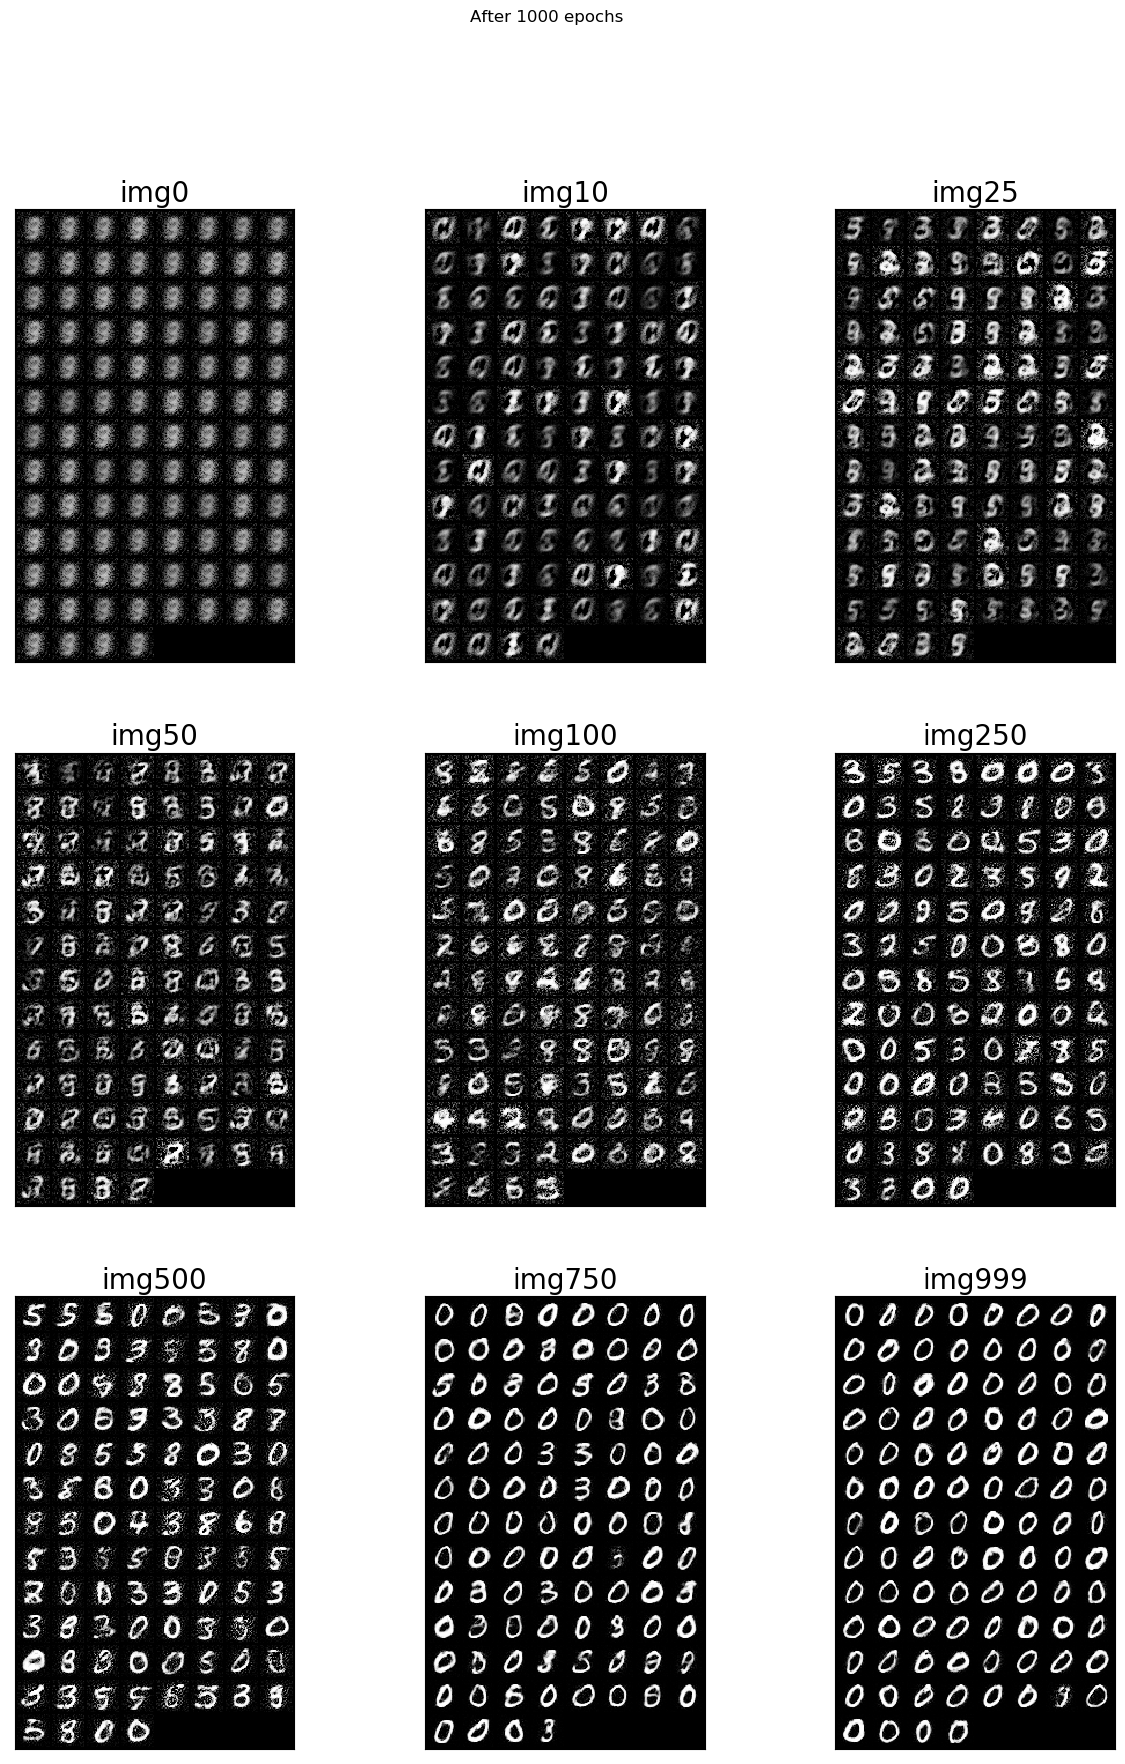

In [102]:
# Load some of the images
from PIL import Image
plt.close('all')
fig,ax = plt.subplots(3,3,figsize=(15,20))
ax = ax.ravel()
img0 = np.array(Image.open('./plots_GAN/gen_img0.png'))
img10 = np.array(Image.open('./plots_GAN/gen_img10.png'))
img25 = np.array(Image.open('./plots_GAN/gen_img25.png'))
img50 = np.array(Image.open('./plots_GAN/gen_img50.png'))
img100 = np.array(Image.open('./plots_GAN/gen_img100.png'))
img250 = np.array(Image.open('./plots_GAN/gen_img250.png'))
img500 = np.array(Image.open('./plots_GAN/gen_img500.png'))
img750 = np.array(Image.open('./plots_GAN/gen_img750.png'))
img999 = np.array(Image.open('./plots_GAN/gen_img999.png'))

ax[0].imshow(img0, cmap='gray'); #set colormap as 'gray'
ax[0].set_title("img0", fontsize=20)
ax[1].grid(False), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(img10, cmap='gray'); #set colormap as 'gray'
ax[1].set_title("img10", fontsize=20);
ax[1].grid(False), ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].imshow(img25, cmap='gray'); #set colormap as 'gray'
ax[2].set_title("img25", fontsize=20)
ax[2].grid(False), ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].imshow(img50, cmap='gray'); #set colormap as 'gray'
ax[3].set_title("img50", fontsize=20)
ax[3].grid(False), ax[3].set_xticks([]), ax[3].set_yticks([])
ax[4].imshow(img100, cmap='gray'); #set colormap as 'gray'
ax[4].set_title("img100", fontsize=20)
ax[4].grid(False), ax[4].set_xticks([]), ax[4].set_yticks([])
ax[5].imshow(img250, cmap='gray'); #set colormap as 'gray'
ax[5].set_title("img250", fontsize=20)
ax[5].grid(False), ax[5].set_xticks([]), ax[5].set_yticks([])
ax[6].imshow(img500, cmap='gray'); #set colormap as 'gray'
ax[6].set_title("img500", fontsize=20)
ax[6].grid(False), ax[6].set_xticks([]), ax[6].set_yticks([])
ax[7].imshow(img750, cmap='gray'); #set colormap as 'gray'
ax[7].set_title("img750", fontsize=20)
ax[7].grid(False), ax[7].set_xticks([]), ax[7].set_yticks([])
ax[8].imshow(img999, cmap='gray'); #set colormap as 'gray'
ax[8].set_title("img999", fontsize=20)
ax[8].grid(False), ax[8].set_xticks([]), ax[8].set_yticks([])
fig.suptitle('After 1000 epochs')

In [119]:
# Loading the GAN trained until 100 epochs

## Redo for the best result architecture (likely sigmoid)
class FeedForwardNet(nn.Module):
    def __init__(self, in_dim,hid_dim,out_dim,verbose=False):
        super(FeedForwardNet, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Linear function
        out =  self.relu(self.fc1(x))
        out =  self.fc2(out)
        return out

hid_dim = 256
num_epochs = 1000
nz = 100# dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss().to(device)
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/generator_100epochs_v2.pt'))
discriminator.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/discriminator_100epochs_v2.pt'))
model_FF = FeedForwardNet(in_dim=784,hid_dim=hid_dim,out_dim=10,verbose=True).to(device)
model_FF.load_state_dict(torch.load('/gpfs/ysm/home/ahf38/Documents/homework/Assignment 3/models/model_FF.pt'))

<All keys matched successfully>

torch.Size([1000, 1, 28, 28])
i: 0, count: 0
out: tensor([[3.6283e-02, 1.0974e-09, 9.6238e-05, 2.8889e-05, 8.3226e-05, 9.4792e-07,
         9.5861e-01, 1.0086e-06, 4.8966e-03, 3.7394e-07]], device='cuda:0')
i: 10, count: 1
out: tensor([[4.1479e-14, 1.3543e-09, 1.0000e+00, 1.6746e-09, 9.0058e-21, 2.3274e-10,
         1.5162e-12, 2.0197e-11, 8.0441e-08, 3.0134e-12]], device='cuda:0')
i: 20, count: 2
out: tensor([[9.9891e-01, 1.5934e-13, 6.4158e-09, 2.3033e-10, 1.0407e-10, 9.1112e-08,
         1.0858e-03, 1.4937e-13, 2.2264e-10, 5.4819e-11]], device='cuda:0')
i: 30, count: 3
out: tensor([[1.5947e-15, 5.4716e-16, 1.5247e-07, 2.7103e-14, 2.3007e-08, 1.9832e-07,
         1.0000e+00, 1.5002e-16, 9.3603e-12, 1.7009e-12]], device='cuda:0')
i: 40, count: 4
out: tensor([[5.9318e-10, 4.7720e-10, 6.4826e-03, 9.9343e-01, 3.0172e-13, 4.1946e-13,
         4.5166e-09, 1.0556e-06, 8.5441e-05, 7.4493e-15]], device='cuda:0')
i: 50, count: 5
out: tensor([[1.0000e+00, 6.5489e-20, 1.6123e-08, 6.1362e-15, 2.9

/gpfs/ysm/project/dietrich/ahf38/conda_envs/homeworks/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


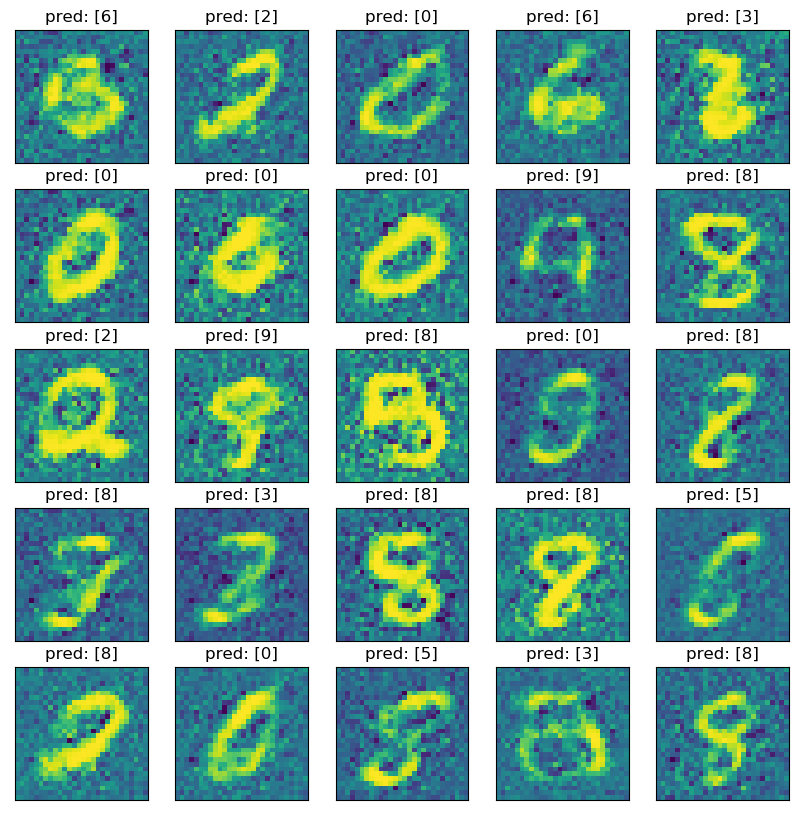

In [122]:
# Generate 1000 samples: and classify some
from torch.autograd import Variable
fig,ax = plt.subplots(5,5,figsize=(10,10))
ax = ax.ravel()
with torch.no_grad():
    generator.eval()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (1000, nz)))).to(device)
    generated_img = generator(z)
    print(generated_img.shape)
    # save the generated torch tensor images
    count=0
    for i in range(generated_img.shape[0]):
        if i %10 == 0 and count < 25:
            save_image(generated_img[i,0,:,:], f"./samples_GAN/sample{i}.png")
            print('i: {}, count: {}'.format(i, count))
            data = generated_img[i,0,:,:].flatten()
            model_input = data.view(-1,data.size(0)).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            out = model_FF(model_input)
            out = F.softmax(out)
            print('out: {}'.format(out))
            _, predicted = torch.max(out, 1)
            ax[count].imshow(generated_img[i,0,:,:].cpu())
            ax[count].grid(False), ax[count].set_xticks([]), ax[count].set_yticks([])
            ax[count].set_title('pred: {}'.format(predicted.cpu().numpy()))
            count += 1
        

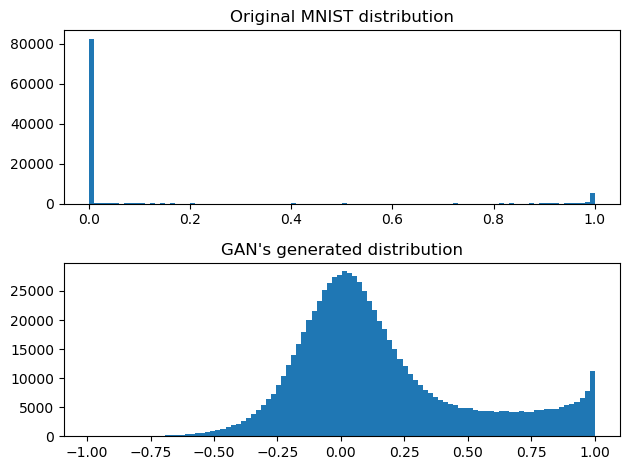

In [123]:
# checking the distributions
fig,ax = plt.subplots(2,1)
# ax=ax.ravel()
data, targets = next(iter(test_loader))
ax[0].hist(data.flatten(),bins=100)
ax[0].set_title("Original MNIST distribution")
ax[1].hist(generated_img[:,0,:,:].cpu().numpy().flatten(),bins=100)
ax[1].set_title("GAN's generated distribution")
plt.tight_layout()

## Question 4.2.1. 
__Which generates more realistic images: your GAN, or your VAE? Why do you think this is?__

Based on the results shown above from both the VAE and GAN, we can verify that the images genertaed by GAN are more realistic. This difference is a consequence of the different approach employed by the two methods. While the vanilla VAE is a powerful method for obtaining useful latent representations, it is also known for generating blurry images. On the other hand, GAN are capable of achieving more realistic images due to its discriminator, which pushes the generator to produce better images based on the capacity of the discriminator to differentiate real and fakes samples, although it suffers from mode collapse as observed on the samples above.

## Question 4.2.2. 
__Does your GAN appear to generate all digits in equal number, or has it specialized in a smaller number of digits? If so, why might this be?__

The results obtained with GAN show a severe degree of mode collapse on 'zero' digits after 100 epochs. We can see that in the first 100 epochs, the networks covered a greater variate of digits, but with less realistic outputs. As the training progressed, the network tends to get specialized on a single digit. This a consequence of the GAN design, which uses two competing networks for learning how to generate images. As the generator improves its generative capacity for a specific digit, the capacity of the discriminator in classifying the digit as real or fake is diminished. As the discriminator stops improving regarding classifying that digit, it is easy for the genertor to generate reasonably good images for that one specific digit. Exploring other modes at this point would necessarily increase the loss, which is then avoided by the generator of the vanilla GAN.



# Section 5 - Information Theory

## Section 5.1

In [131]:
# sample 100 points from a 3D uniform distribution
from scipy.stats import multivariate_normal
from scipy.stats import uniform
from scipy.stats import entropy
import numpy as np
from scipy import stats
from time import perf_counter 
import torch

import cv2
print(cv2.__version__)


# def img_to_sig(arr):
#     """Convert a 2D array to a signature for cv2.EMD"""
    
#     # cv2.EMD requires single-precision, floating-point input
# #     print('arr.shape: ',arr.shape)
#     sig = np.empty((arr.size, 2), dtype=np.float32)
#     count = 0
#     for i in range(arr.shape[0]):
# #         for j in range(arr.shape[1]):
# #             for k in range(arr.shape[2]):
# #                 print('i,j,l: ',i,j,k)
#         sig[count] = np.array([arr[i], i])
#         count += 1
#     return sig

# x = np.linspace(-1,1,1000, endpoint=False)
# x, y = np.mgrid[-1:1:.01, -1:1:.01]
# pos = np.dstack((x, y))
# dist1 = uniform()
# dist2 = multivariate_normal(mean = [0, 0], cov = [[1, 0], [0, 1]])
# dist2 = multivariate_normal(mean = 0, cov = 0)
# print('dist1.shape: {}'.format(dist1.shape))
# print('dist2.shape: {}'.format(dist2.shape))
# fig,ax = plt.subplots(2,1)
# count, bins, ignored = ax[0].hist(dist1.flatten(), 15, density=True)
# ax[0].plot(bins, np.ones_like(bins), linewidth=2, color='r')
# ax[0].set_title('Uniform distribution')
# count, bins, ignored = ax[1].hist(dist2.flatten(), 15, density=True)
# ax[1].plot(bins, np.ones_like(bins), linewidth=2, color='r')
# ax[1].set_title('Normal distribution')
# fig.tight_layout()

4.4.0


In [132]:
# sig1_f = img_to_sig(sig1)

In [133]:
# MDD
# ----- Functions for Part 5 -----
def mmd(X,Y, kernel_fn):
    """
    Implementation of Maximum Mean Discrepancy.
    :param X: An n x 1 numpy vector containing the samples from distribution 1.
    :param Y: An n x 1 numpy vector containing the samples from distribution 2.
    :param kernel_fn: supply the kernel function to use.
    :return: the maximum mean discrepancy:
    MMD(X,Y) = Expected value of k(X,X) + Expected value of k(Y,Y) - Expected value of k(X,Y)
    where k is a kernel function
    """
#     K = kernel_fn(X,Y)
    K_XX, K_XY, K_YY = kernel_fn(X, Y)
    m = K_XX.shape[0]
#     K_XX = K[:m, :m] 
#     K_XY = K[:m, m:]
#     K_YY = K[m:, m:]
    
    diag_X = torch.diag(K_XX)                       # (m,)
    diag_Y = torch.diag(K_YY)                       # (m,)
    sum_diag_X = torch.sum(diag_X)
    sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()    
    
    mmd = (Kt_XX_sum / (m * (m - 1)) + Kt_YY_sum / (m * (m - 1)) - 2.0 * K_XY_sum / (m * m))
    
    return mmd


def kernel(A, B):
    """
    A gaussian kernel on two arrays.
    :param A: An n x d numpy matrix containing the samples from distribution 1
    :param B: An n x d numpy matrix containing the samples from distribution 2.
    :return K:  An n x n numpy matrix k, in which k_{i,j} = e^{-||A_i - B_j||^2/(2*sigma^2)}
    """

    assert(A.shape[0] == B.shape[0])
#     print(A)
    m = A.shape[0]

    Z = torch.cat((A, B), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
#     for sigma in sigma_list:
    sigma = 0.1
    gamma = 1.0 / (2 * sigma**2)
    K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:]

#     return K

In [134]:
# # Compute KL divergence 

# # from scipy.stats import entropy
# # d1 = dist1.pdf(pos)
# # print(d1.shape)
# # d2 = dist2.pdf(pos)
# # print(d2.shape)
# # entropy(d1[:,:,0], qk=d2, axis=0)

# # fig2 = plt.figure()
# # ax2 = fig2.add_subplot(111)
# # ax2.contourf(x, y, d2)

# # fig2 = plt.figure()
# # ax3 = fig2.add_subplot(111)
# # ax3.contourf(x, y, d1[:,:,1])
# data = np.array([[1, 4, 3], [2, .6, 1.2], [2, 1, 1.2],
#          [2, 0.5, 1.4], [5, .5, 0], [0, 0, 0],
#          [1, 4, 3], [5, .5, 0], [2, .5, 1.2]])

# print(data.shape)
# data = data.T
# kde = stats.gaussian_kde(data)

# minima = data.T.min(axis=0)
# maxima = data.T.max(axis=0)
# space = [np.linspace(mini,maxi,20) for mini, maxi in zip(minima,maxima)]
# print('space: ',space)
# grid = np.meshgrid(*space)
# print('grid[0].shape: ',grid[0].shape)

# #Turn the grid into N-dimensional coordinates for each point
# #Note - coords will get very large as N increases...
# coords = np.vstack(map(np.ravel, grid))
# print('coords: ',coords)
# print('coords.shape: ',coords.shape)
# #Evaluate the KD estimated pdf at each coordinate
# density = kde(coords)
# print('density.shape: ',density.shape)

In [40]:
# Compute KL divergence
from sklearn.neighbors import KernelDensity
dist1 = uniform().rvs(size=(1000,3))
dist2 = multivariate_normal(mean = [0,0,0], cov = [[1,0,0], [0,1,0], [0,0,1]]).rvs(size=(1000))


# print('dist1.shape: {}'.format(dist1.shape))
# print('dist2.shape: {}'.format(dist2.shape))

# minima = data.T.min(axis=0)
# maxima = data.T.max(axis=0)
# print('minima: {}', minima)
# print('minima.shape: {}', minima.shape)
def img_to_sig(arr):
    """Convert a 2D array to a signature for cv2.EMD"""
    
    # cv2.EMD requires single-precision, floating-point input
#     print('arr.shape: ',arr.shape)
    sig = np.empty((arr.size, 4), dtype=np.float32)
    count = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
#                 print('i,j,l: ',i,j,k)
                sig[count] = np.array([arr[i,j,k], i, j,k])
                count += 1
    return sig

minima = np.ones([3,1])*-1
maxima = np.ones([3,1])

space = [np.linspace(mini,maxi,20) for mini, maxi in zip(minima,maxima)]
# print('space: ',space)
grid = np.meshgrid(*space)
# print('grid[0].shape: ',grid[0].shape)

#Turn the grid into N-dimensional coordinates for each point
#Note - coords will get very large as N increases...
coords = np.vstack(map(np.ravel, grid))
# print('coords: ',coords)
# print('coords.shape: ',coords.shape)

#Evaluate the KD estimated pdf at each coordinate
# dist1 = dist1.T
# kde = stats.gaussian_kde(dist1)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist1)
# sig1 = kde(coords)
sig1 = kde.score_samples(dist1)

# dist2 = dist2.T
# kde = stats.gaussian_kde(dist2)
# sig2 = kde(coords)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist2)
sig2 = kde.score_samples(dist2)

# sig1 = kde.fit(dist1)
# sig2 = kde.fit(dist2)

# kde.score_samples(xy)
                  
# sig1 = KernelDensity(dist1)

# sig1, bin_edges1 = np.histogramdd(dist1, bins=5, density=True)
# sig2, bin_edges2 = np.histogramdd(dist2, bins=5, density=True)
# # np.histogramm not good. KDE.

# print('sig1.shape: {}'.format(sig1.shape))
# print('bin_edges1: {}'.format(bin_edges1))
# print('sig2.shape.: {}'.format(sig2.shape))
# print('bin_edges2: {}'.format(bin_edges2))

print('Computing KL divergence')
t1_start = perf_counter()  
print('\nentropy(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
print('\nentropy(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
print('\nentropy(sig1, sig1): \n{}'.format(entropy(sig1, sig1)))
print('\nentropy(sig2, sig2): \n{}'.format(entropy(sig2, sig2)))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 

Computing KL divergence

entropy(sig1, sig2): 
0.025243586148913852

entropy(sig2, sig1): 
0.02604318995631357

entropy(sig1, sig1): 
0.0

entropy(sig2, sig2): 
0.0
Elapsed time :  0.0010313400998711586


/gpfs/ysm/project/dietrich/ahf38/conda_envs/homeworks/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [115]:
# # Compute EMD
# print(sig1.shape)
# # sig1=sig1.reshape(20,20,20)
# # sig2=sig2.reshape(20,20,20)
# print('sig1.shape: ',sig1.shape)
# # sig1_f = img_to_sig(sig1)
# # sig2_f = img_to_sig(sig2)

# t1_start = perf_counter()  
# # dist, _, flow = cv2.EMD(sig1_f, sig2_f, cv2.DIST_L2)
# dist, _, flow = cv2.EMD(sig1, sig2, cv2.DIST_L2)
# t1_stop = perf_counter() 
# print("Elapsed time : ",t1_stop-t1_start) 

# print(dist)
# print(_)
# print(flow)

In [5]:
# Distance between the two arrays
t1_start = perf_counter()  
dist, _, flow = cv2.EMD(sig1_f, sig1_f, cv2.DIST_L2)
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 

print(dist)
print(_)
print(flow)

Elapsed time :  427.79463456291705
0.0003840590361505747
None
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.26909435 0.         0.        ]
 [0.         0.         0.         ... 0.         0.29663327 0.        ]
 [0.         0.         0.         ... 0.         0.         0.19320157]]


In [12]:
# print(kernel)
# dist1 = dist1.T
# dist2 = dist2.T
print(dist1.shape)
print(dist2.shape)
t1_start = perf_counter() 
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
print(res)
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist1), kernel)
print(res)
res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist2), kernel)
print(res)
res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
print(res)
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 

(1000, 3)
(1000, 3)
tensor(0.0113)
tensor(-0.0020)
tensor(-0.0020)
tensor(0.0113)
Elapsed time :  0.11581282317638397


In [135]:
## Variance=10
from time import perf_counter 

# KL Divergence
variance = 1
print('variance: {}'.format(variance))
dist1 = uniform().rvs(size=(1000,3))
dist2 = multivariate_normal(mean = [0, 0, 0], cov = [[variance, 0, 0], [0, variance, 0], [0,0,variance]]).rvs(size=(1000))

# plt.close('all')
# fig,ax = plt.subplots(2,1)
# ax = ax.ravel()
# ax[0].hist(dist1.flatten())
# ax[1].hist(dist2.flatten())

# minima = np.ones([3,1])*-1
# maxima = np.ones([3,1])

# space = [np.linspace(mini,maxi,20) for mini, maxi in zip(minima,maxima)]
# grid = np.meshgrid(*space)

# #Turn the grid into N-dimensional coordinates for each point
# #Note - coords will get very large as N increases...
# coords = np.vstack(map(np.ravel, grid))

#Evaluate the KD estimated pdf at each coordinate
# dist1 = dist1.T
# kde = stats.gaussian_kde(dist1)
# sig1 = kde(coords)

# dist2 = dist2.T
# kde = stats.gaussian_kde(dist2)
# sig2 = kde(coords)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist1)
sig1 = kde.score_samples(dist1)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist2)
sig2 = kde.score_samples(dist2)

print('Computing KL divergence')
t1_start = perf_counter()  
print('entropy(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
print('entropy(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
print('entropy(sig1, sig1): \n{}'.format(entropy(sig1, sig1)))
print('entropy(sig2, sig2): \n{}'.format(entropy(sig2, sig2)))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 


# t1_start = perf_counter()  
# print('\nKLD(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
# print('\nKLD(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
# t1_stop = perf_counter() 
# print("Elapsed time : ",t1_stop-t1_start) 

print('\nComputing EMD')
# sig1=sig1.reshape(20,20,20)
# sig2=sig2.reshape(20,20,20)
# print('sig1.shape: ',sig1.shape)
sig1_f = img_to_sig(np.exp(sig1))
sig2_f = img_to_sig(np.exp(sig2))

t1_start = perf_counter()  
dist, _, flow = cv2.EMD(sig1_f, sig2_f, cv2.DIST_L2)
print('EMD(sig1,sig2):', dist)
dist, _, flow = cv2.EMD(sig1_f, sig1_f, cv2.DIST_L2)
print('EMD(sig1,sig1):', dist)
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 
# print(_)
# print(flow)


print('\nComputing MMD')
# dist1 = dist1.T
# dist2 = dist2.T
t1_start = perf_counter() 
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
print('MMD(dist1, dist2): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
print('MMD(dist2, dist1): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist1), kernel)
print('MMD(dist1, dist1): \n{}'.format(res))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 

variance: 1
Computing KL divergence
entropy(sig1, sig2): 
0.027704913538102185
entropy(sig2, sig1): 
0.028360331040819448
entropy(sig1, sig1): 
0.0
entropy(sig2, sig2): 
0.0
Elapsed time :  0.0010058293119072914

Computing EMD
EMD(sig1,sig2): 5.963588237762451
EMD(sig1,sig1): 0.0
Elapsed time :  2.6517836675047874

Computing MMD
MMD(dist1, dist2): 
0.011260931380093098
MMD(dist2, dist1): 
0.011260930448770523
MMD(dist1, dist1): 
-0.0019757412374019623
Elapsed time :  0.06338193360716105


In [136]:
## Variance=10
from time import perf_counter 

# KL Divergence
variance = 10
print('variance: {}'.format(variance))
dist1 = uniform().rvs(size=(1000,3))
dist2 = multivariate_normal(mean = [0, 0, 0], cov = [[variance, 0, 0], [0, variance, 0], [0,0,variance]]).rvs(size=(1000))

# plt.close('all')
# fig,ax = plt.subplots(2,1)
# ax = ax.ravel()
# ax[0].hist(dist1.flatten())
# ax[1].hist(dist2.flatten())

# minima = np.ones([3,1])*-1
# maxima = np.ones([3,1])

# space = [np.linspace(mini,maxi,20) for mini, maxi in zip(minima,maxima)]
# grid = np.meshgrid(*space)

# #Turn the grid into N-dimensional coordinates for each point
# #Note - coords will get very large as N increases...
# coords = np.vstack(map(np.ravel, grid))

#Evaluate the KD estimated pdf at each coordinate
# dist1 = dist1.T
# kde = stats.gaussian_kde(dist1)
# sig1 = kde(coords)

# dist2 = dist2.T
# kde = stats.gaussian_kde(dist2)
# sig2 = kde(coords)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist1)
sig1 = kde.score_samples(dist1)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist2)
sig2 = kde.score_samples(dist2)

print('Computing KL divergence')
t1_start = perf_counter()  
print('entropy(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
print('entropy(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
print('entropy(sig1, sig1): \n{}'.format(entropy(sig1, sig1)))
print('entropy(sig2, sig2): \n{}'.format(entropy(sig2, sig2)))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 


# t1_start = perf_counter()  
# print('\nKLD(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
# print('\nKLD(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
# t1_stop = perf_counter() 
# print("Elapsed time : ",t1_stop-t1_start) 

print('\nComputing EMD')
# sig1=sig1.reshape(20,20,20)
# sig2=sig2.reshape(20,20,20)
# print('sig1.shape: ',sig1.shape)
sig1_f = img_to_sig(np.exp(sig1))
sig2_f = img_to_sig(np.exp(sig2))

t1_start = perf_counter()  
dist, _, flow = cv2.EMD(sig1_f, sig2_f, cv2.DIST_L2)
print('EMD(sig1,sig2):', dist)
dist, _, flow = cv2.EMD(sig1_f, sig1_f, cv2.DIST_L2)
print('EMD(sig1,sig1):', dist)
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 
# print(_)
# print(flow)


print('\nComputing MMD')
# dist1 = dist1.T
# dist2 = dist2.T
t1_start = perf_counter() 
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
print('MMD(dist1, dist2): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
print('MMD(dist2, dist1): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist1), kernel)
print('MMD(dist1, dist1): \n{}'.format(res))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 

variance: 10
Computing KL divergence
entropy(sig1, sig2): 
0.010780243838458582
entropy(sig2, sig1): 
0.010726785001495414
entropy(sig1, sig1): 
0.0
entropy(sig2, sig2): 
0.0
Elapsed time :  0.0009416937828063965

Computing EMD
EMD(sig1,sig2): 0.07855956256389618
EMD(sig1,sig1): 0.0
Elapsed time :  2.749250890687108

Computing MMD
MMD(dist1, dist2): 
0.012487843632698059
MMD(dist2, dist1): 
0.012487843632698059
MMD(dist1, dist1): 
-0.0019750315696001053
Elapsed time :  0.0639765989035368


In [137]:
## Variance=10
from time import perf_counter 

# KL Divergence
variance = 100
print('variance: {}'.format(variance))
dist1 = uniform().rvs(size=(1000,3))
dist2 = multivariate_normal(mean = [0, 0, 0], cov = [[variance, 0, 0], [0, variance, 0], [0,0,variance]]).rvs(size=(1000))

# plt.close('all')
# fig,ax = plt.subplots(2,1)
# ax = ax.ravel()
# ax[0].hist(dist1.flatten())
# ax[1].hist(dist2.flatten())

# minima = np.ones([3,1])*-1
# maxima = np.ones([3,1])

# space = [np.linspace(mini,maxi,20) for mini, maxi in zip(minima,maxima)]
# grid = np.meshgrid(*space)

# #Turn the grid into N-dimensional coordinates for each point
# #Note - coords will get very large as N increases...
# coords = np.vstack(map(np.ravel, grid))

#Evaluate the KD estimated pdf at each coordinate
# dist1 = dist1.T
# kde = stats.gaussian_kde(dist1)
# sig1 = kde(coords)

# dist2 = dist2.T
# kde = stats.gaussian_kde(dist2)
# sig2 = kde(coords)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist1)
sig1 = kde.score_samples(dist1)
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(dist2)
sig2 = kde.score_samples(dist2)

print('Computing KL divergence')
t1_start = perf_counter()  
print('entropy(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
print('entropy(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
print('entropy(sig1, sig1): \n{}'.format(entropy(sig1, sig1)))
print('entropy(sig2, sig2): \n{}'.format(entropy(sig2, sig2)))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 


# t1_start = perf_counter()  
# print('\nKLD(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
# print('\nKLD(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
# t1_stop = perf_counter() 
# print("Elapsed time : ",t1_stop-t1_start) 

print('\nComputing EMD')
# sig1=sig1.reshape(20,20,20)
# sig2=sig2.reshape(20,20,20)
# print('sig1.shape: ',sig1.shape)
sig1_f = img_to_sig(np.exp(sig1))
sig2_f = img_to_sig(np.exp(sig2))

t1_start = perf_counter()  
dist, _, flow = cv2.EMD(sig1_f, sig2_f, cv2.DIST_L2)
print('EMD(sig1,sig2):', dist)
dist, _, flow = cv2.EMD(sig1_f, sig1_f, cv2.DIST_L2)
print('EMD(sig1,sig1):', dist)
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 
# print(_)
# print(flow)


print('\nComputing MMD')
# dist1 = dist1.T
# dist2 = dist2.T
t1_start = perf_counter() 
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
print('MMD(dist1, dist2): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
print('MMD(dist2, dist1): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist1), kernel)
print('MMD(dist1, dist1): \n{}'.format(res))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 

variance: 100
Computing KL divergence
entropy(sig1, sig2): 
0.008011823933460338
entropy(sig2, sig1): 
0.007981354037720543
entropy(sig1, sig1): 
0.0
entropy(sig2, sig2): 
0.0
Elapsed time :  0.001005701720714569

Computing EMD
EMD(sig1,sig2): 0.0
EMD(sig1,sig1): 0.0
Elapsed time :  2.873311223462224

Computing MMD
MMD(dist1, dist2): 
0.012103630229830742
MMD(dist2, dist1): 
0.012103630229830742
MMD(dist1, dist1): 
-0.0019757822155952454
Elapsed time :  0.06473454460501671


## Question 5.1.1. 
__Based on the above measures alone, which divergence seems most accurate?__

According to the tests perfomed above for distances/divergences between two diffrent distributions (hereafter referered to as "inter-distribution") or between a distribution and itself (used for control and hereafter refered to as "intra-distribution"), we can verify that KLD and EMD present divergence/distance equal to zero for intra-distributions while MMD presents a value close to zero. These results indicate a better performance for the EMD and KLD to identify highly similar distributions when compared to MMD. Moreover, the results obtained for different variances in the inter-distributions setups (1,10 and 100) show that EMD drops to zero faster than KLD as the variance is increased. This behavior might be desirable for a more qualitative comparison between distributions and be used to guide the loss function during GAN's training. We can also observe that the distance provided by MMD does not change in function of the variance. This is an implication of the MMD method, which does not use density estimation for the distance computation, but rather the empirical distribution. Therefore, simply based on the results above, EMD seems to better match our expectations for the experiments performed.

## Section 5.2

dist1.shape: torch.Size([1000, 784])

Computing MMD
MMD(dist1, dist2): 
-0.0001839984761318192
MMD(dist2, dist1): 
-0.00018400153203401715
Elapsed time :  0.09458391927182674

Computing KL divergence
entropy(sig1, sig2): 
-1.0658141036401514e-17
entropy(sig2, sig1): 
1.0658141036401498e-17
entropy(sig1, sig1): 
0.0
entropy(sig2, sig2): 
0.0
Elapsed time :  0.0030185356736183167

Computing EMD
EMD(sig1,sig2): 0.0
EMD(sig1,sig1): 0.0
Elapsed time :  1.653316255658865


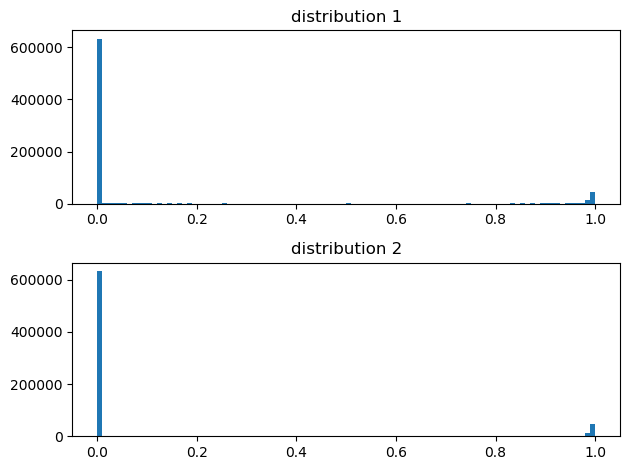

In [130]:
def img_to_sig(arr):
    """Convert a 2D array to a signature for cv2.EMD"""
    
    # cv2.EMD requires single-precision, floating-point input
#     print('arr.shape: ',arr.shape)
    sig = np.empty((arr.size, 2), dtype=np.float32)
    count = 0
    for i in range(arr.shape[0]):
#         for j in range(arr.shape[1]):
#             for k in range(arr.shape[2]):
#                 print('i,j,l: ',i,j,k)
        sig[count] = np.array([arr[i], i])
        count += 1
    return sig


large_batch2 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=True)

# Sample 1000 samples from test set 
dist1, _ = next(iter(large_batch2))
dist1 = dist1.view(1000,-1)

dist2, _ = next(iter(large_batch2))
dist2 = dist2.view(1000,-1)

print('dist1.shape: {}'.format(dist1.shape))

plt.close('all')
fig,ax = plt.subplots(2,1)
ax[0].hist(dist1.flatten(),bins=100)
ax[0].set_title("distribution 1")
ax[1].hist(dist2.flatten(),bins=100)
ax[1].set_title("distribution 2")
plt.tight_layout()

# sig1, bin_edges1 = np.histogramdd(dist1, bins=5, density=True)
# sig2, bin_edges2 = np.histogramdd(dist2, bins=5, density=True)

# print('\nKLD(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
# print('\nKLD(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))

# MMD
# res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
# print('\nMMD(dist1, dist2): \n{}'.format(res))
# res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
# print('\nMMD(dist2, dist1): \n{}'.format(res))

# plt.close('all')
# fig,ax = plt.subplots(2,1)
# ax = ax.ravel()
# ax[0].hist(dist1.flatten(),bins=100);
# ax[1].hist(dist2.flatten(),bins=100);

## Variance=10
# from time import perf_counter 

# KL Divergence
# variance = 100
# print('variance: {}'.format(variance))
# dist1 = uniform().rvs(size=(1000,3))
# dist2 = multivariate_normal(mean = [0, 0, 0], cov = [[variance, 0, 0], [0, variance, 0], [0,0,variance]]).rvs(size=(1000))

# plt.close('all')
# fig,ax = plt.subplots(2,1)
# ax = ax.ravel()
# ax[0].hist(dist1.flatten())
# ax[1].hist(dist2.flatten())

print('\nComputing MMD')
# dist1 = dist1.T
# dist2 = dist2.T
t1_start = perf_counter() 
res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
print('MMD(dist1, dist2): \n{}'.format(res))
res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
print('MMD(dist2, dist1): \n{}'.format(res))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 


# minima = np.ones([784,1])*-1
# maxima = np.ones([784,1])

# space = [np.linspace(mini,maxi,20) for mini, maxi in zip(minima,maxima)]
# print('len(space): ',len(space))
# # print('space: ',space)
# grid = np.meshgrid(*space)

# #Turn the grid into N-dimensional coordinates for each point
# #Note - coords will get very large as N increases...
# coords = np.vstack(map(np.ravel, grid))

#Evaluate the KD estimated pdf at each coordinate
# dist1 = dist1.T
# ax[0].hist(dist1.flatten())
dist1_v2 = dist1 #+ torch.rand(dist1.shape)*0.1 # Add a bit of noise to avoid a singular matrix
# ax[1].hist(dist1_v2.flatten())
# kde = stats.gaussian_kde(dist1_v2)
# sig1 = kde(coords)
dist1_v2 = dist1_v2.numpy()
kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(dist1_v2)
sig1 = kde.score_samples(dist1_v2)
# print(sig1.shape)


# dist2 = dist2.T
dist2_v2 = dist2 #+ torch.rand(dist2.shape)*0.5 # Add a bit of noise to avoid a singular matrix
dist2_v2 = dist2_v2.numpy()
# print('Min max dist1_v2:')
# print(np.min(dist2_v2))
# print(np.max(dist2_v2))
# kde = stats.gaussian_kde(dist2_v2)
# sig2 = kde(coords)
kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(dist2_v2)
sig2 = kde.score_samples(dist2_v2)
# print('Min max sig2:')
# print(np.min(sig2))
# print(np.max(sig2))

# print('Min max np.exp(sig2):')
# print(np.min(np.exp(sig2)))
# print(np.max(np.exp(sig2)))

print('\nComputing KL divergence')
t1_start = perf_counter()  
print('entropy(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
print('entropy(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
print('entropy(sig1, sig1): \n{}'.format(entropy(sig1, sig1)))
print('entropy(sig2, sig2): \n{}'.format(entropy(sig2, sig2)))
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 


# t1_start = perf_counter()  
# print('\nKLD(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
# print('\nKLD(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
# t1_stop = perf_counter() 
# print("Elapsed time : ",t1_stop-t1_start) 

print('\nComputing EMD')
# sig1=sig1.reshape(20,20,20)
# sig2=sig2.reshape(20,20,20)
# print('sig1.shape: ',sig1.shape)
# sig1_f = img_to_sig(np.exp(sig1))
# sig2_f = img_to_sig(np.exp(sig2))
sig1_f = img_to_sig(sig1)
sig2_f = img_to_sig(sig2)
# print(sig1_f)

t1_start = perf_counter()  
dist, _, flow = cv2.EMD(sig1_f, sig2_f, cv2.DIST_L2)
print('EMD(sig1,sig2):', dist)
dist, _, flow = cv2.EMD(sig1_f, sig1_f, cv2.DIST_L2)
print('EMD(sig1,sig1):', dist)
t1_stop = perf_counter() 
print("Elapsed time : ",t1_stop-t1_start) 
# print(_)
# print(flow)


In [37]:
print(sig1[:10])
pow(sig1[:10],2)

[-183.92817575 -183.92817575 -183.92817575 -183.92817575 -183.92817575
 -183.92817575 -183.92817575 -183.92817575 -183.92817575 -183.92817575]


array([33829.57383562, 33829.57383562, 33829.57383562, 33829.57383562,
       33829.57383562, 33829.57383562, 33829.57383562, 33829.57383562,
       33829.57383562, 33829.57383562])

## Section 5.3

generated_img.shape:  torch.Size([1000, 1, 28, 28])
torch.Size([1000, 784])

Computing MMD
MMD(dist1, dist2): 
0.0
MMD(dist2, dist1): 
0.0
Elapsed time :  0.09923702944070101

Computing KL divergence
entropy(sig1, sig2): 
-1.1013412404281555e-16
entropy(sig2, sig1): 
1.1013412404281553e-16
entropy(sig1, sig1): 
0.0
entropy(sig2, sig2): 
0.0
Elapsed time :  0.004786139354109764

Computing EMD
EMD(sig1,sig2): 0.0
Elapsed time :  0.8222413277253509


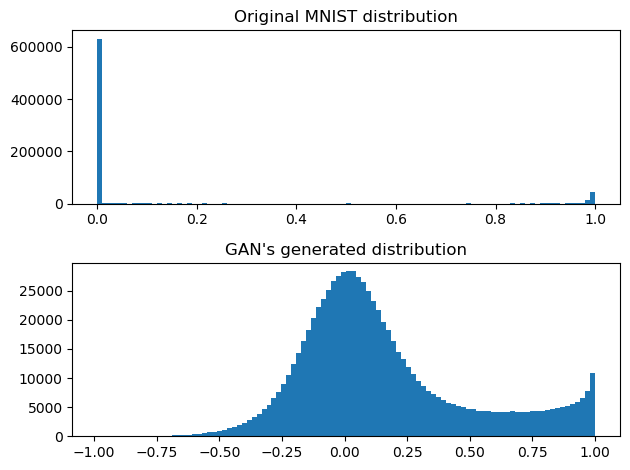

In [127]:
# Compare the samples generated with GAN and the original 

# Sample 1000 samples from test set 
dist1, _ = next(iter(large_batch2))
dist1 = dist1.view(1000,-1)

# Generate 1000 samples: and classify some
from torch.autograd import Variable
# nz = 100# dimension of random noise
# generator = Generator(nz).to(device)
# fig,ax = plt.subplots(3,3,figsize=(10,10))
# ax = ax.ravel()
with torch.no_grad():
    generator.eval()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (1000, nz)))).to(device)
    generated_img = generator(z)
    print('generated_img.shape: ',generated_img.shape)
    

    plt.close('all')
    fig,ax = plt.subplots(2,1)
    ax[0].hist(dist1.flatten(),bins=100)
    ax[0].set_title("Original MNIST distribution")
    ax[1].hist(generated_img[:,0,:,:].cpu().numpy().flatten(),bins=100)
    ax[1].set_title("GAN's generated distribution")
    plt.tight_layout()


#     ax = ax.ravel()
#     ax[0].hist(dist1.flatten(),bins=100);
#     ax[1].hist(dist2.flatten(),bins=100);

#     generated_img = make_grid(generated_img[:10,:,:,:].reshape(10,1,28,28))
#     print(generated_img.shape)
    # fig,ax = plt.subplots(2,1)
    save_image(generated_img, f"./gen_img_test.png")

    dist2 = generated_img.view(1000,-1).cpu()
    print(dist2.shape)
    # # MMD
    # res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
    # print('\nMMD(dist1, dist2): \n{}'.format(res))
    # res = mmd(torch.FloatTensor(dist2.cpu()),torch.FloatTensor(dist1), kernel)
    # print('\nMMD(dist2, dist1): \n{}'.format(res))

    # plt.close('all')
    # fig,ax = plt.subplots(2,1)
    # ax = ax.ravel()
    # ax[0].hist(dist1.flatten(),bins=100);
    # ax[1].hist(dist2.flatten(),bins=100);

    print('\nComputing MMD')
    # dist1 = dist1.T
    # dist2 = dist2.T
    t1_start = perf_counter() 
    res = mmd(torch.FloatTensor(dist1),torch.FloatTensor(dist2), kernel)
    print('MMD(dist1, dist2): \n{}'.format(res))
    res = mmd(torch.FloatTensor(dist2),torch.FloatTensor(dist1), kernel)
    print('MMD(dist2, dist1): \n{}'.format(res))
    t1_stop = perf_counter() 
    print("Elapsed time : ",t1_stop-t1_start) 


    # minima = np.ones([784,1])*-1
    # maxima = np.ones([784,1])

    dist1_v2 = dist1 #+ torch.rand(dist1.shape)*0.1 # Add a bit of noise to avoid a singular matrix
    # ax[1].hist(dist1_v2.flatten())
    # kde = stats.gaussian_kde(dist1_v2)
    # sig1 = kde(coords)
    dist1_v2 = dist1_v2.numpy()
    kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(dist1_v2)
    sig1 = kde.score_samples(dist1_v2)

    dist2_v2 = dist2 #+ torch.rand(dist2.shape)*0.5 # Add a bit of noise to avoid a singular matrix
    dist2_v2 = dist2_v2.numpy()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(dist2_v2)
    sig2 = kde.score_samples(dist2_v2)
    # print('Min max sig2:')
    # print(np.min(sig2))
    # print(np.max(sig2))

    # print('Min max np.exp(sig2):')
    # print(np.min(np.exp(sig2)))
    # print(np.max(np.exp(sig2)))

    print('\nComputing KL divergence')
    t1_start = perf_counter()  
    print('entropy(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
    print('entropy(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
    print('entropy(sig1, sig1): \n{}'.format(entropy(sig1, sig1)))
    print('entropy(sig2, sig2): \n{}'.format(entropy(sig2, sig2)))
    t1_stop = perf_counter() 
    print("Elapsed time : ",t1_stop-t1_start) 


    # t1_start = perf_counter()  
    # print('\nKLD(sig1, sig2): \n{}'.format(entropy(sig1, sig2)))
    # print('\nKLD(sig2, sig1): \n{}'.format(entropy(sig2, sig1)))
    # t1_stop = perf_counter() 
    # print("Elapsed time : ",t1_stop-t1_start) 

    print('\nComputing EMD')
    # sig1=sig1.reshape(20,20,20)
    # sig2=sig2.reshape(20,20,20)
    # print('sig1.shape: ',sig1.shape)
    # sig1_f = img_to_sig(np.exp(sig1))
    # sig2_f = img_to_sig(np.exp(sig2))
    sig1_f = img_to_sig(sig1)
    sig2_f = img_to_sig(sig2)


    t1_start = perf_counter()  
    dist, _, flow = cv2.EMD(sig1_f, sig2_f, cv2.DIST_L2)
    t1_stop = perf_counter() 
    print('EMD(sig1,sig2):', dist)
    print("Elapsed time : ",t1_stop-t1_start) 
    # print(_)
    # print(flow)



## Question 5.3.1. 
__Which divergence or distance showed the greatest discrepancy between the comparison between real MNIST data and the comparison with the GAN?__

All the methods presented distance/divergence either equal to zero or sufficiently small. 

## Question 5.3.2. 
__Which of these information measures would you recommend for judging a GAN's output? Why?__

All the three methods tested seem to perform satifactory in the experiments done above. From these methods, EMD seems to be the most appropriate. 

The loss fucntion in a vanilla GAN consists of a JS divergence. The use of divergences can be problematic for cases in which the distributions are disjoint, which is a possibilty according to the srchitecture of the networks. EMD can still provide a meaninful representation of the between distributions, thus placing EMD as the recommended measure.

<!-- Wasserstein metric is proposed to replace JS divergence because it has a much smoother value space. See more in the next section.

The loss function of the vanilla GAN measures the JS divergence between the distributions of pr and pg. 

Even when two distributions are located in lower dimensional manifolds without overlaps, Wasserstein distance can still provide a meaningful and smooth representation of the distance in-between.

The WGAN paper exemplified the idea with a simple exampl -->

## Question 5.3.3. 
__How do the runtimes of these measures compare?__

The KLD is consistently the fastest method, with MMD in second and EMD in third. 

In [9]:
# dist1 = uniform().entropy()
# dist2 = multivariate_normal(mean = [0, 0], cov = [[1, 0], [0, 1]]).rvs(size=(1000))

In [62]:
# import scipy.stats as stats
# x, y = np.mgrid[-1:1:.01, -1:1:.01]
# pos = np.dstack((x, y))
# print(pos.shape)

# pk = dist1.pdf(pos)
# qk = dist2.pdf(pos)

# print(qk.evaluate(pos))
# entropy(sig1, sig2)

In [63]:
# from sklearn.neighbors import KernelDensity

# # instantiate and fit the KDE model
# kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
# kde.fit(dist2)

# # score_samples returns the log of the probability density
# logprob = kde.score_samples(dist2)

In [66]:
# # print(logprob.shape)
# print(dist1.shape)
# plt.plot(logprob)

In [98]:
# # Compute EMD
# import cv2

# def img_to_sig(arr):
#     """Convert a 2D array to a signature for cv2.EMD"""
    
#     # cv2.EMD requires single-precision, floating-point input
#     sig = np.empty((arr.size, 3), dtype=np.float32)
#     count = 0
#     for i in range(arr.shape[0]):
#         for j in range(arr.shape[1]):
#             sig[count] = np.array([arr[i,j], i, j])
#             count += 1
#     return sig

# sig1 = uniform()
# dist2 = multivariate_normal(mean = [0, 0], cov = [[1, 0], [0, 1]])

# sig1 = img_to_sig(dist1)
# sig2 = img_to_sig(dist2)

# dist, _, flow = cv2.EMD(sig1, sig2, cv2.DIST_L2)

# print(dist)
# print(_)
# print(flow)

In [18]:
arr1 = np.array([[2, 0, 0],
                 [2, 0, 0],
                 [0, 0, 2]])

arr2 = np.array([[0, -1, 1],
                 [2, 0, 0],
                 [0, 2, 0]])

# sig1 = img_to_sig(arr1)
# sig2 = img_to_sig(arr2)
sig1, bin_edges1 = np.histogramdd(arr1, density=True)
sig2, bin_edges2 = np.histogram(arr2, density=True)
# print(sig1.shape)

print(sig1)
print(bin_edges1)
print(sig2)
print(bin_edges2)

dist, _, flow = cv2.EMD(np.float32(sig1), np.float32(sig2), cv2.DIST_L2)

print(dist)
print(_)
print(flow)

[3.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         1.66666667]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]
[0.37037037 0.         0.         1.85185185 0.         0.
 0.37037037 0.         0.         0.74074074]
[-1.  -0.7 -0.4 -0.1  0.2  0.5  0.8  1.1  1.4  1.7  2. ]


error: OpenCV(4.4.0) /tmp/pip-req-build-cg56sov1/opencv/modules/imgproc/src/emd.cpp:230: error: (-201:Incorrect size of input array) Number of dimensions can be 0 only if a user-defined metric is used in function 'cvCalcEMD2'


In [33]:
r = np.random.randn(100,3)
print(r.shape)
H, edges = np.histogramdd(r)
print(H)
H.shape, edges[0].size, edges[1].size, edges[2].size

(100, 3)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 2. 1. 0. 1. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 

((10, 10, 10), 11, 11, 11)